In [1]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
import scipy.stats as stats
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
from bisect import bisect_left
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 22})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [15, 10]
from IPython.display import Audio, display
def allDone():
    display(Audio(filename='beep.mp3', autoplay=True))
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
import lmfit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
import emcee
import corner
import numdifftools
from scipy.ndimage import interpolation
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from multiprocessing import Pool
import pickle
import h5py
import multiprocessing
import itertools
from multiprocessing import sharedctypes
import scipy
from PyAstronomy.pyasl import dopplerShift

In [2]:
def get_spectrum(source_id):
    path = wdtable[wdtable['source_id'] == source_id][0]['specpath']
    try:
        with fits.open(path) as f:
            flux = f[1].data['flux']
            loglam = f[1].data['loglam']
            fluxsig = f[1].data['ivar']
            lam = 10**loglam
            f.close()
    except:
        print('Spectrum file missing...')
        return
    return lam,flux,fluxsig

def adapted_ch_cont(array,continuum,sigarray = None):
    spec = array
    notnan = ~np.isnan(spec)
    p = np.polynomial.chebyshev.chebfit(lamgrid[continuum*notnan],spec[continuum*notnan],10)
    cont = np.polynomial.chebyshev.chebval(lamgrid,p)
    contcorr = spec / cont
    if sigarray is not None:
        stdev = np.sqrt(1.0/sigarray)
        contsigarray = stdev / cont
        normivar = (1.0/contsigarray)**2
        return contcorr,normivar
    return contcorr

def norm_dataspec(array,sigarray=None):
    contcorr,contsig = adapted_ch_cont(array,continuum,sigarray)
    skylinemask = (lamgrid > 5578.5 - 10)*(lamgrid < 5578.5 + 10) + (lamgrid > 5894.6 - 10)*(lamgrid < 5894.6 + 10)\
        + (lamgrid > 6301.7 - 10)*(lamgrid < 6301.7 + 10) + (lamgrid > 7246.0 - 10)*(lamgrid < 7246.0 + 10)
    contcorr[skylinemask] = 1
    #where = np.isnan(contcorr)+(contcorr > 1.25) + (contcorr < 0)
    #contcorr[where] = 1
    return contcorr,contsig


## Model

In [4]:
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,scale,MinMaxScaler,StandardScaler
import multiprocessing

In [4]:
sc = MinMaxScaler()

In [5]:
## Load Model Spectra

searchparameter = '_'

prefilenames = os.listdir('koester2/')
filenames = []
for i in range(len(prefilenames)):
    if searchparameter in prefilenames[i]:
        filenames.append(prefilenames[i])
        
len(filenames)

modelspectra = [];
modelwl = [];
loggs = [];
teffs = [];
for i in (filenames):
    specname=i
    f = open('koester2/'+specname)
    data = f.readlines()
    f.close()
    headerdata = data[0:7]
    spectraldata = data[6:]
    lam = []
    flux = []

    for i in range(len(spectraldata)):
        l=float(spectraldata[i].split()[0])
        lam.append(l)
        f = float(spectraldata[i].split()[1])
        flux.append(f)

    lam = np.asarray(lam)
    flux = np.asarray(flux) / 1e7

    teff = float(headerdata[1].split()[3])
    logg = float(headerdata[2].split()[3])
    
    in1 = find_nearest(lam,4000)
    in2 = find_nearest(lam,8000)

    flux = flux[in1:in2]
    lam = lam[in1:in2]
    
    flux = flux[:-1][~ (np.diff(lam) == 0)]
    lam = lam[:-1][~ (np.diff(lam) == 0)]
    
    lamgrid = np.arange(4000,8000)
    
    func = interp1d(lam,flux,kind='linear',assume_sorted = False,fill_value='extrapolate')
    flux = func(lamgrid)
    
    modelspectra.append(flux)
    modelwl.append(lam)
    teffs.append(teff)
    loggs.append(logg)

modelspectra = np.asarray(modelspectra)
loggs = np.asarray(loggs)
teffs = np.asarray(teffs)

In [6]:
pixels = np.arange(0,4000)
continuum = (pixels > 2900) + (pixels < 2200)*(pixels > 1200) + (pixels < 650)*(pixels > 530) \
            + (pixels < 35)*(pixels > 20) + (pixels < 220)*(pixels > 200)

norm_modelspectra = [adapted_ch_cont(i,continuum) for i in modelspectra]
norm_modelspectra = np.asarray(norm_modelspectra)

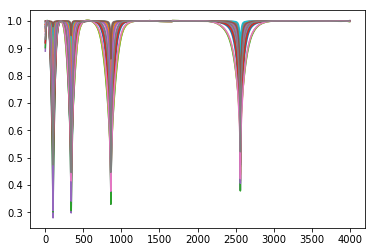

In [9]:
plt.plot(norm_modelspectra[2:20].T);

In [16]:
np.min(X,0)

array([5500. ,    6.5])

In [22]:
X = np.stack((teffs,loggs)).T
t = norm_modelspectra

dummylabel = np.array([[5500,6.5],[80000, 9.5]])
sc.fit(dummylabel)
X_scaled = sc.transform(X)
t_scaled = t#msc.fit_transform(t)

In [61]:
H = 32
reg = 0.0001
def generator():
    x = Input(shape=(2,))
    y = Dense(32,activation='sigmoid',trainable = True)(x)
    y = Dense(32,activation='sigmoid',trainable = True)(y)
    out = Dense(4000,activation='linear',trainable = True)(y)
    
    model = Model(inputs = x, outputs = out)
    model.compile(optimizer = Adamax(lr = 0.002), loss = 'mse', \
                  metrics = ['mae'])
    return model
model = generator()
history = [];
#model.load_weights('DAGEN.h5')
print(model.summary())

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_15 (Dense)             (None, 4000)              132000    
Total params: 133,152
Trainable params: 133,152
Non-trainable params: 0
_________________________________________________________________
None


In [64]:
for i in tqdm(range(2500)): 
    print('Training meta-batch %i'%i)
    
    n_epochs = 10
    batch = 64
    
    
    h = model.fit(X_scaled,t_scaled, epochs = n_epochs, verbose = 1, batch_size = batch, shuffle = True)
    history = np.append(history, h.history['loss'])
    model.save_weights('DAGEN.h5')
    #model.save('DAGEN.h5')







  0%|          | 0/2500 [00:00<?, ?it/s]

Training meta-batch 0
Epoch 1/10
1040/1040 [==============================] - 0s 64us/step - loss: 2.0897e-06 - mae: 6.0760e-04
Epoch 2/10
1040/1040 [==============================] - 0s 64us/step - loss: 2.0577e-06 - mae: 6.3089e-04
Epoch 3/10
1040/1040 [==============================] - 0s 65us/step - loss: 2.0926e-06 - mae: 7.0406e-04
Epoch 4/10
1040/1040 [==============================] - 0s 63us/step - loss: 2.0641e-06 - mae: 6.1728e-04
Epoch 5/10
1040/1040 [==============================] - 0s 64us/step - loss: 2.0406e-06 - mae: 6.2103e-04
Epoch 6/10
1040/1040 [==============================] - 0s 61us/step - loss: 2.1174e-06 - mae: 6.5671e-04
Epoch 7/10
1040/1040 [==============================] - 0s 57us/step - loss: 2.1991e-06 - mae: 7.3703e-04
Epoch 8/10
1040/1040 [==============================] - 0s 61us/step - loss: 2.2790e-06 - mae: 7.9844e-04
Epoch 9/10
1040/1040 [==============================] - 0s 61us/step - loss: 1.9719e-06 - mae: 5.7320e-04
Epoch 10/10
1040/1040 [=







  0%|          | 1/2500 [00:00<28:44,  1.45it/s]

Training meta-batch 1
Epoch 1/10
1040/1040 [==============================] - 0s 61us/step - loss: 2.0199e-06 - mae: 5.7393e-04
Epoch 2/10
1040/1040 [==============================] - 0s 68us/step - loss: 1.9838e-06 - mae: 5.4606e-04
Epoch 3/10
1040/1040 [==============================] - 0s 66us/step - loss: 2.1112e-06 - mae: 6.6691e-04
Epoch 4/10
1040/1040 [==============================] - 0s 60us/step - loss: 2.1430e-06 - mae: 6.4540e-04
Epoch 5/10
1040/1040 [==============================] - 0s 60us/step - loss: 2.2105e-06 - mae: 7.8770e-04
Epoch 6/10
1040/1040 [==============================] - 0s 61us/step - loss: 2.0161e-06 - mae: 5.8519e-04
Epoch 7/10
1040/1040 [==============================] - 0s 62us/step - loss: 2.0766e-06 - mae: 6.2671e-04
Epoch 8/10
1040/1040 [==============================] - ETA: 0s - loss: 1.9886e-06 - mae: 5.5433e-0 - 0s 66us/step - loss: 2.0108e-06 - mae: 5.6333e-04
Epoch 9/10
1040/1040 [==============================] - 0s 67us/step - loss: 2.0348e







  0%|          | 2/2500 [00:01<28:58,  1.44it/s]

Training meta-batch 2
Epoch 1/10
1040/1040 [==============================] - 0s 69us/step - loss: 2.3539e-06 - mae: 8.6627e-04
Epoch 2/10
1040/1040 [==============================] - 0s 61us/step - loss: 2.1247e-06 - mae: 7.3836e-04
Epoch 3/10
1040/1040 [==============================] - 0s 70us/step - loss: 2.0664e-06 - mae: 7.0800e-04
Epoch 4/10
1040/1040 [==============================] - 0s 62us/step - loss: 2.0142e-06 - mae: 5.5472e-04
Epoch 5/10
1040/1040 [==============================] - 0s 70us/step - loss: 2.0344e-06 - mae: 5.7203e-04
Epoch 6/10
1040/1040 [==============================] - 0s 67us/step - loss: 2.1011e-06 - mae: 6.3327e-04
Epoch 7/10
1040/1040 [==============================] - 0s 67us/step - loss: 2.0544e-06 - mae: 5.5957e-04
Epoch 8/10
1040/1040 [==============================] - 0s 69us/step - loss: 2.1049e-06 - mae: 6.8135e-04
Epoch 9/10
1040/1040 [==============================] - 0s 63us/step - loss: 1.9876e-06 - mae: 5.5067e-04
Epoch 10/10
1040/1040 [=







  0%|          | 3/2500 [00:02<29:19,  1.42it/s]

Training meta-batch 3
Epoch 1/10
1040/1040 [==============================] - 0s 66us/step - loss: 2.0350e-06 - mae: 6.1004e-04
Epoch 2/10
1040/1040 [==============================] - 0s 72us/step - loss: 2.2259e-06 - mae: 7.9774e-04
Epoch 3/10
1040/1040 [==============================] - 0s 69us/step - loss: 2.0400e-06 - mae: 6.3255e-04
Epoch 4/10
1040/1040 [==============================] - 0s 61us/step - loss: 1.9779e-06 - mae: 6.0205e-04
Epoch 5/10
1040/1040 [==============================] - 0s 69us/step - loss: 2.0329e-06 - mae: 5.9919e-04
Epoch 6/10
1040/1040 [==============================] - 0s 62us/step - loss: 1.9501e-06 - mae: 5.6080e-04
Epoch 7/10
1040/1040 [==============================] - 0s 61us/step - loss: 2.0817e-06 - mae: 6.2160e-04
Epoch 8/10
1040/1040 [==============================] - 0s 61us/step - loss: 2.1970e-06 - mae: 7.4623e-04
Epoch 9/10
1040/1040 [==============================] - 0s 67us/step - loss: 1.9939e-06 - mae: 5.9652e-04
Epoch 10/10
1040/1040 [=







  0%|          | 4/2500 [00:02<29:21,  1.42it/s]

Training meta-batch 4
Epoch 1/10
  64/1040 [>.............................] - ETA: 0s - loss: 1.9140e-06 - mae: 5.5316e-04

KeyboardInterrupt: 

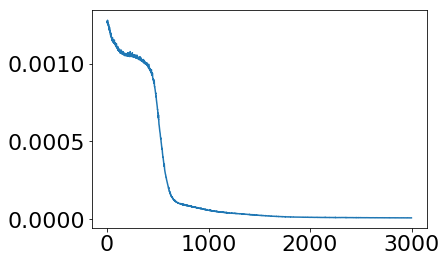

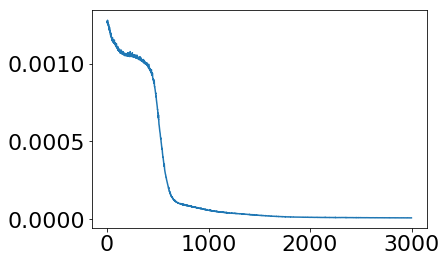

In [41]:
plt.plot(history)

plt.figure()
plt.plot(history[-10000:])

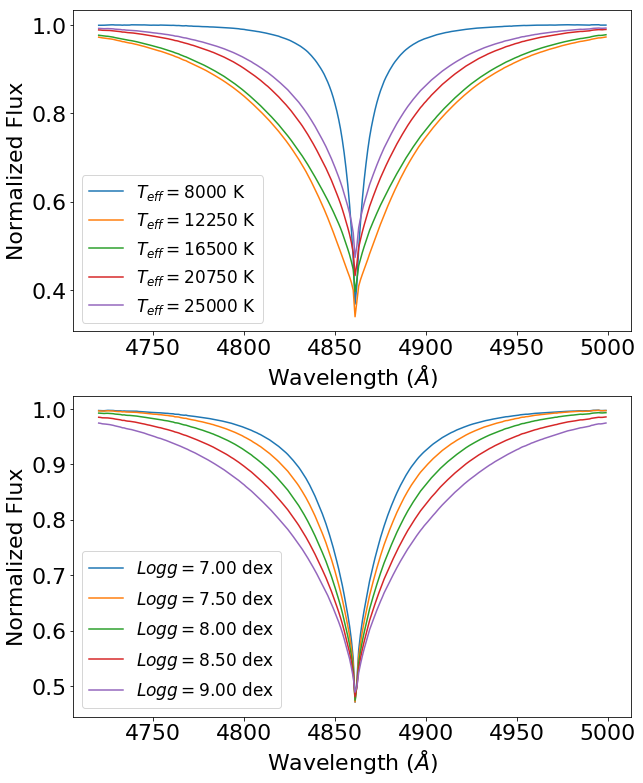

In [42]:
plt.figure(figsize=(10,13))

plt.subplot(211)
ts = np.linspace(8000,25000,5)
ls = np.linspace(8,8,5)
plt.rcParams.update({'font.size': 22})             
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = (model.predict(samples))
tscores = (ts - np.min(ts))/(np.max(ts) - np.min(ts))
for i in range(len(gens)):
    plt.plot(lamgrid[720:1000],adapted_ch_cont(gens[i],continuum)[720:1000],label='$T_{eff} = %i$ K'%ts[i])
plt.legend(fontsize=17)
plt.ylabel('Normalized Flux')
plt.xlabel('Wavelength ($\AA$)')

plt.subplot(212)
ts = np.linspace(25000,25000,5)
ls = np.linspace(7,9,5)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = (model.predict(samples))
tscores = (ts - np.min(ts))/(np.max(ts) - np.min(ts))
for i in range(len(gens)):
    plt.plot(lamgrid[720:1000],adapted_ch_cont(gens[i],continuum)[720:1000],label='$Logg = %.2f$ dex'%ls[i])
plt.legend(fontsize=17)
plt.ylabel('Normalized Flux')
plt.xlabel('Wavelength ($\AA$)')

plt.savefig('nn_label.pdf')

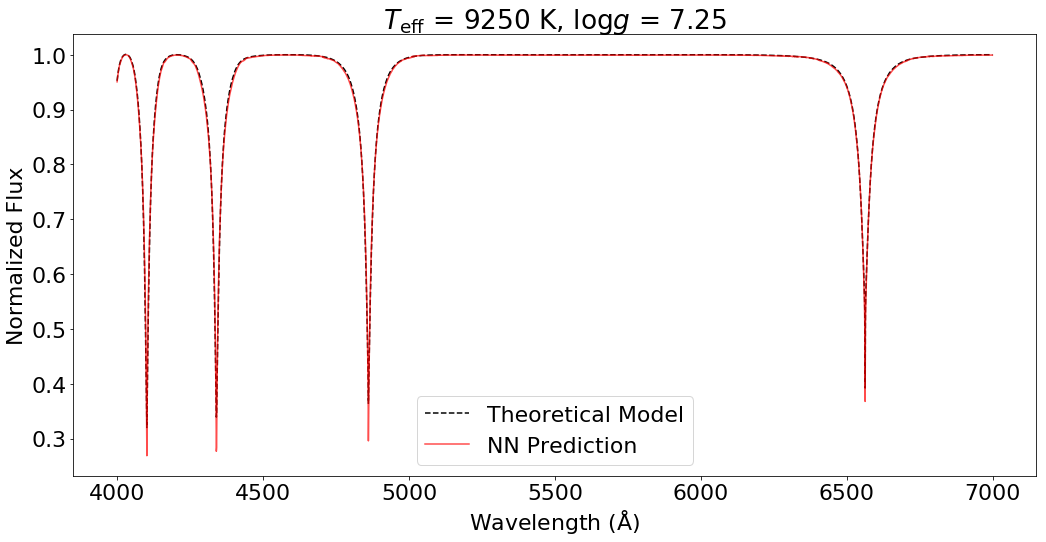

In [54]:
kk = np.random.randint(0,1023)
plt.figure(figsize=(15,8))
label = sc.transform(np.stack((teffs[kk],loggs[kk])).reshape(1,-1))
plt.plot(lamgrid[0:3000],norm_modelspectra[kk][0:3000],'k--', label = 'Theoretical Model')
plt.plot(lamgrid[0:3000],np.ravel((model.predict(label)))[0:3000],'r', label = 'NN Prediction',alpha = 0.7)
plt.title('$T_{\mathrm{eff}}$ = %i K, $\log{g}$ = %.2f'%(teffs[kk],loggs[kk]))
plt.legend()
plt.xlabel('Wavelength ($\mathrm{\AA}$)')
plt.ylabel('Normalized Flux')
plt.tight_layout()
plt.savefig('genspec.pdf')

In [55]:
%%time
(model.predict(label))

CPU times: user 976 µs, sys: 325 µs, total: 1.3 ms
Wall time: 804 µs


array([[0.9506784 , 0.95536107, 0.9600351 , ..., 0.9994348 , 0.9993633 ,
        0.99960274]], dtype=float32)

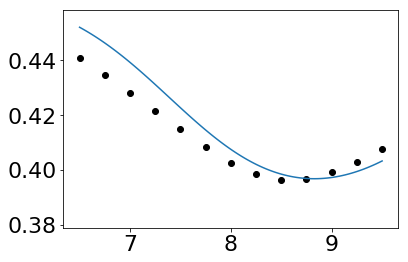

In [59]:
pixel = int(hbeta)-4000

temp = 15000


ts = teffs[teffs == temp]
ls = loggs[teffs == temp]
labels = np.stack((ts,ls)).T
tflux =(t)[teffs == temp][:,pixel]

plt.scatter(ls,tflux,color='k')

linls = np.linspace(min(ls),max(ls),100)
lints = np.repeat(temp,100)
linlabels = np.stack((lints,linls)).T
lintflux = (model.predict(sc.transform(linlabels)))[:,pixel]
plt.plot(linls,lintflux)

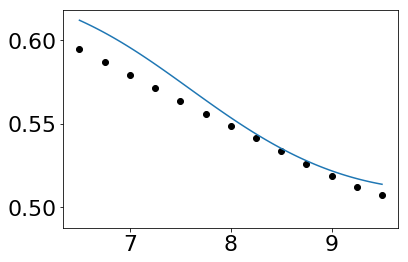

In [58]:
pixel = int(halpha)-4000

temp = 14000


ts = teffs[teffs == temp]
ls = loggs[teffs == temp]
labels = np.stack((ts,ls)).T
tflux = (t)[teffs == temp][:,pixel]

plt.scatter(ls,tflux,color='k')

linls = np.linspace(min(ls),max(ls),100)
lints = np.repeat(temp,100)
linlabels = np.stack((lints,linls)).T
lintflux = (model.predict(sc.transform(linlabels)))[:,pixel]
plt.plot(linls,lintflux)

In [211]:
100*np.mean(np.abs(np.ravel(msc.inverse_transform(t)) - np.ravel(msc.inverse_transform(model.predict(X))))/np.ravel(msc.inverse_transform(t)))

1.4843456317036667

In [212]:
lines = ((lamgrid > hbeta-200) & (lamgrid < hbeta + 300)) | ((lamgrid > halpha-250) & (lamgrid < halpha + 300))\
        | ((lamgrid > hgamma-120) & (lamgrid < hgamma + 400))| ((lamgrid > hdelta-90) & (lamgrid < hdelta + 150))
def spectrum_sampler(wl,teff,logg,trans):
    label = sc.transform(np.asarray(np.stack((teff,logg)).reshape(1,-1)))
    synth = dopplerShift(wl,np.ravel(
                        msc.inverse_transform(
                                model.predict(label))[0]
                        ), trans*1000
                    )[0]
    return (np.ravel(synth).astype('float64'))

def norm_spectrum_sampler(wl,teff,logg,trans):
    synth = spectrum_sampler(lamgrid,teff,logg,trans)
    return synth[lines]

def chisquare(residual):
    return sum(residual**2)

def get_prior_teff(array):
    spec = np.asarray(array)
    priorfitter = lmfit.Model(spectrum_sampler)
    priorparams = priorfitter.make_params()
    priorparams['logg'].set(value = 8., vary = False)
    priorparams['teff'].set(value = 10000,min = 5500, max = 80000)
    priorparams['trans'].set(value = 0., vary = False)
    priorfitter.eval(priorparams, wl = lamgrid)
    prior_result = priorfitter.fit(spec, priorparams, wl = lamgrid, method = 'Powell', nan_policy = 'omit');
    #print(prior_result.fit_report())
    return prior_result.params['teff'].value

def get_posteriors(array, n_eval = 3000):
    spec = array
    normspec = adapted_ch_cont(spec,continuum)
    def chisq(params):
        teff,logg,trans = params
        res = normspec[lines] - norm_spectrum_sampler(lamgrid,teff,logg,trans)
        res = res[~np.isnan(res)]
        chisq = np.sum(res**2)
        return chisq
    teff_init = get_prior_teff(spec)
   # p = scipy.optimize.minimize(chisq, bounds = [(5500,80000),(6.5,9.5),(-3,3)], x0 = [teff_init, 8., 0],\
                             #  method = 'dual_annealing')
    p = scipy.optimize.dual_annealing(chisq,bounds = [(5500,80000),(6.5,9.5),(-3,3)],maxfun = n_eval,\
                                      x0 = [teff_init, 8., 0])
    #p = scipy.optimize.differential_evolution(chisq,bounds = [(5500,80000),(6.5,9.5),(-3,3)],\
       #                              disp = True)
    
#     plt.plot(normspec[lines])
#     plt.plot(norm_spectrum_sampler(lamgrid,p.x[0],p.x[1],p.x[2]))
    return p.x

## Test on Synthetics

In [213]:
searchparameter = '_'

prefilenames = os.listdir('koester2/')
filenames = []
for i in range(len(prefilenames)):
    if searchparameter in prefilenames[i]:
        filenames.append(prefilenames[i])
        
len(filenames)

modelspectra = [];
modelwl = [];
loggs = [];
teffs = [];
for i in (filenames):
    specname=i
    f = open('koester2/'+specname)
    data = f.readlines()
    f.close()
    headerdata = data[0:7]
    spectraldata = data[6:]
    lam = []
    flux = []

    for i in range(len(spectraldata)):
        l=float(spectraldata[i].split()[0])
        lam.append(l)
        f = float(spectraldata[i].split()[1])
        flux.append(f)

    lam = np.asarray(lam)
    flux = np.asarray(flux) / 1e7

    teff = float(headerdata[1].split()[3])
    logg = float(headerdata[2].split()[3])
    
    in1 = find_nearest(lam,4000)
    in2 = find_nearest(lam,8000)

    flux = flux[in1:in2]
    lam = lam[in1:in2]
    
    flux = flux[:-1][~ (np.diff(lam) == 0)]
    lam = lam[:-1][~ (np.diff(lam) == 0)]
    
    lamgrid = np.arange(4000,8000)
    
    func = interp1d(lam,flux,kind='linear',assume_sorted = False,fill_value='extrapolate')
    flux = func(lamgrid)
    
    modelspectra.append(flux)
    modelwl.append(lam)
    teffs.append(teff)
    loggs.append(logg)

modelspectra = np.asarray(modelspectra)
loggs = np.asarray(loggs)
teffs = np.asarray(teffs)

In [214]:
screen = (teffs > 7000) * (teffs < 40000)*(loggs > 7)*(loggs <9)

modelspectra = modelspectra[screen]
teffs = teffs[screen]
loggs = loggs[screen]

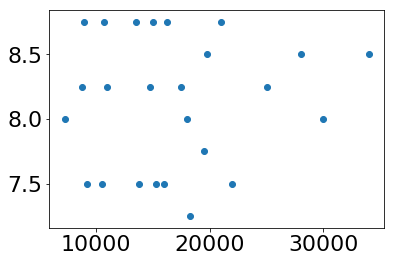

In [215]:
plt.scatter(teffs[0:25],loggs[0:25])












  0%|          | 0/30 [00:00<?, ?it/s]

Finding MLE Point...
MLE Gridpoint: 14618 K, 8.74 dex
Burning in 25 samples... (0 done)
Autocorr Time = 4 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 6 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 9 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior
Result: 15018 ± 676 K, 8.76 ± 0.10 dex


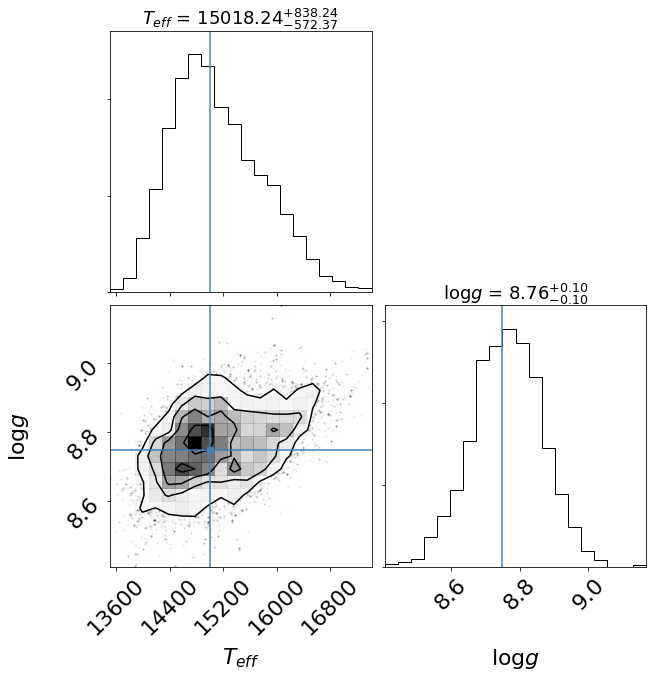

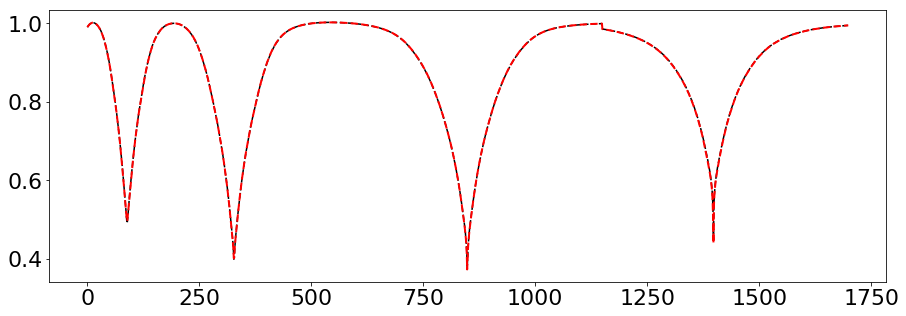












  3%|▎         | 1/30 [00:41<20:15, 41.92s/it]

Finding MLE Point...
MLE Gridpoint: 14024 K, 7.59 dex
Burning in 25 samples... (0 done)
Autocorr Time = 2 samples.
Burn-in terminated with correlation fraction = 0.08
Sampling 100 draws from posterior
Result: 13843 ± 698 K, 7.55 ± 0.15 dex


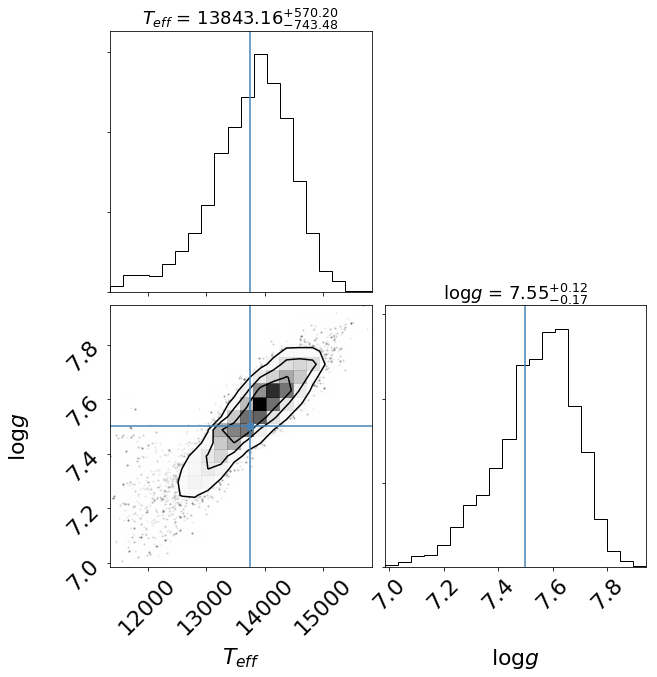

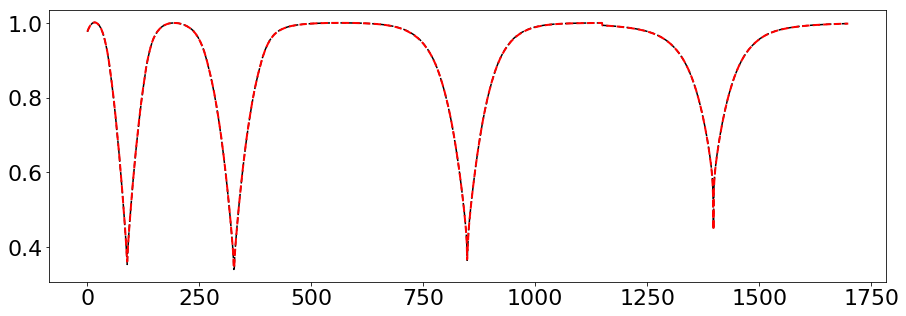












  7%|▋         | 2/30 [01:16<18:28, 39.59s/it]

Finding MLE Point...


KeyboardInterrupt: 

In [216]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
teffgrid = np.linspace(6000,80000,250)
logggrid = np.linspace(6.5,9.5,100)
from itertools import product

searchgrid = (np.vstack((product(teffgrid,logggrid)  )))
results = [];
for ii in tqdm(range(len(modelspectra[0:30]))):
    
    spec = modelspectra[ii]
    #sig = 1
    normspec = adapted_ch_cont(spec,continuum)
    normspec = np.asarray(normspec[lines])
    def lnlike(prms):
        model = norm_spectrum_sampler(lamgrid,prms[0],prms[1],prms[2])
        diff = model - normspec
        
#         plt.plot(model)
#         plt.plot(normspec)
#         plt.plot(diff)
        
        diff = diff[~np.isnan(model)]
        chisq = np.sum(diff**2 / (0.1)**2)
        lnlike = -0.5 * chisq
    #     plt.plot(model)
    #     plt.plot(normspec)
        return lnlike

    def lnprior(prms):
        if prms[0] < 6000 or prms[0] > 80000:
            return -np.Inf
        elif prms[1] < 6.5 or prms[1] > 9.5:
            return -np.Inf
        elif prms[2] < -3 or prms[2] > 3:
            return -np.Inf

        #mu = teff_prior
        #sigma = 5000
        return 0

    def lnprob(prms):
        lp = lnprior(prms)
        if not np.isfinite(lp):
            return -np.Inf
        return lp + lnlike(prms)


    ndim,nwalkers = 3,100


    steps = 100
    burn_step = 25
    total_burned = 0
        

    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,threads = 1)
    
    acorrtime = 1e5
    #Initialize sampler
    print('Finding MLE Point...')
    
    mlept = [15000,8.]
    maxlik = -1e10
    for searchpoint in searchgrid:
        lik = lnlike([searchpoint[0],searchpoint[1],0])
        if lik > maxlik:
            mlept = searchpoint;
            maxlik = lik
            
    print('MLE Gridpoint: %i K, %.2f dex'%(mlept[0],mlept[1]))
    mlpt = np.asarray([mlept[0],mlept[1],0])
    pos1 = np.zeros((nwalkers,ndim))
    ballsigmas = [500, 0.1, 0.05]
    for jj in range(ndim):
        pos1[:,jj] = (mlpt[jj] + ballsigmas[jj] * np.random.randn(nwalkers))
    

    
    b = sampler.run_mcmc(pos1,1) #Initialize
    
    while acorrtime > (0.1 * total_burned):
        print('Burning in %i samples... (%i done)'%(burn_step,total_burned))
        b = sampler.run_mcmc(b[0],burn_step)
        total_burned = total_burned + burn_step
        try:
            acorr_teff = emcee.autocorr.function(sampler.chain[0][:,0])
            acorrtime_teff = np.argmax(acorr_teff < (1/np.exp(1)))
            acorr_logg = emcee.autocorr.function(sampler.chain[0][:,1])
            acorrtime_logg = np.argmax(acorr_logg < (1/np.exp(1)))
            acorrtime = np.mean([acorrtime_teff, acorrtime_logg])
            print('Autocorr Time = %i samples.'%int(acorrtime))
        except :
            print('Chain too short.')
            continue;
            
        if (total_burned > 1000) and (acorrtime != 1e5):
            print('Maximum burn time reached.')
            break;
    
    print('Burn-in terminated with correlation fraction = %.2f'%(acorrtime/total_burned))
    
    n_draws =  100
    print('Sampling %i draws from posterior'%n_draws)
    
    sampler.reset()
    s = sampler.run_mcmc(b[0],int(n_draws))
    values = np.median(sampler.flatchain,0)
    meanvalues = np.mean(sampler.flatchain,0)
    modevalues = stats.mode(sampler.flatchain,0)[0]
    mlevalues = sampler.flatchain[np.argmax(sampler.flatlnprobability)]
    chi2 = -2*lnlike(mlevalues)
    lower = np.quantile(sampler.flatchain,.3173,axis=0)
    upper = np.quantile(sampler.flatchain,.6827,axis=0)
    std = np.std(sampler.flatchain,axis=0)
    print('Result: %i ± %i K, %.2f ± %0.2f dex'%(values[0], std[0], values[1], std[1]))
    results.append([values, meanvalues, modevalues, mlevalues, lower, upper, std, chi2])
    
    fig,axs = plt.subplots(2,2,figsize=(10,10))
    f = corner.corner(sampler.flatchain[:,0:2],show_titles = True,smooth = 0,truths = (teffs[ii],\
            loggs[ii]),labels = ('$T_{eff}$','$\log{g}$'),title_kwargs={'fontsize':18}, fig = fig)
    #plt.savefig('plots/synthmc/'+str(wdtable[ii]['source_id'])+'_corner.png')
    #plt.close()
    plt.show()
    plt.figure(figsize = (15,5))
    #plt.title('Gaia '+str(wdtable[ii]['source_id']))
    plt.plot(normspec,'k--', label = 'Data Spectrum')
    plt.plot(norm_spectrum_sampler(lamgrid,mlevalues[0],mlevalues[1],mlevalues[2]),'r--',\
             label = 'Fitted Synthetic',linewidth=2)
    plt.show()
    #plt.legend()
    #plt.savefig('plots/synthmc/'+str(wdtable[ii]['source_id'])+'_fit.png')
    #plt.close()

In [178]:
loggs[9]

8.75

In [217]:
values = np.asarray(results)[:,3]

In [218]:
fitteffs = [i[0] for i in values]

In [219]:
truths = teffs[0:len(fitteffs)]
preds = np.asarray(fitteffs)

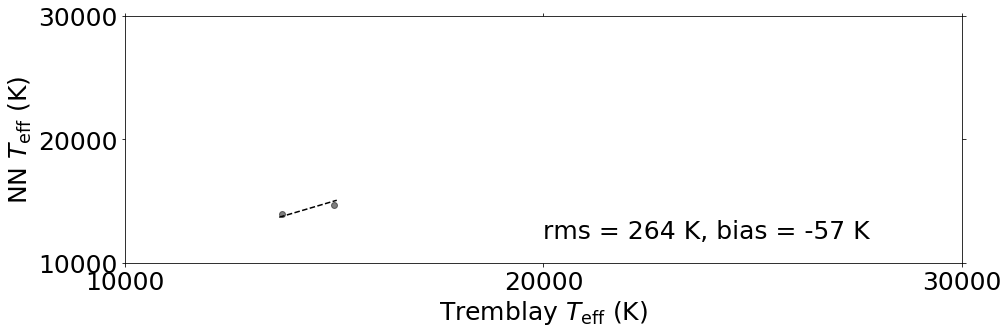

In [220]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 25})

f = plt.subplot(211)

mask = (truths < 40000)
truths = truths[mask]
preds = preds[mask]

plt.scatter(truths,preds,color='k',alpha = 0.5)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
plt.plot(x,x,'k--')

resid = preds - truths
rms = np.sqrt((np.mean(resid**2)))
bias = np.mean(resid)
plt.text(0.5,0.1,'rms = %i K, bias = %i K'%(rms,bias), transform = f.transAxes)
plt.xlabel('Tremblay $T_{\mathrm{eff}}$ (K)')
plt.ylabel('NN $T_{\mathrm{eff}}$ (K)')
f.yaxis.set_ticks(np.arange(10000,40000,10000));
f.xaxis.set_ticks(np.arange(10000,40000,10000));
f.tick_params(top = True,right = True)

In [221]:
fitloggs = [i[1] for i in values]

In [222]:
truths = loggs[0:len(fitloggs)]
preds = np.asarray(fitloggs)

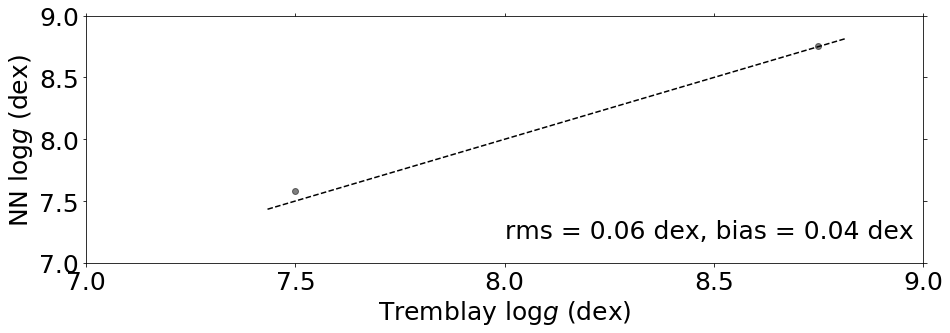

In [223]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 25})

f = plt.subplot(211)

mask = np.abs(truths-preds)<2612
truths = truths[mask]
preds = preds[mask]

plt.scatter(truths,preds,color='k', alpha = 0.5)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
plt.plot(x,x,'k--')

resid = preds - truths
rms = np.sqrt(np.mean(resid**2))
bias = np.mean(resid)
plt.text(0.5,0.1,'rms = %.2f dex, bias = %.2f dex'%(rms,bias), transform = f.transAxes);
f.tick_params(top = True,right = True)
plt.xlabel('Tremblay $\log{g}$ (dex)')
plt.ylabel('NN $\log{g}$ (dex)')
f.yaxis.set_ticks(np.arange(7,9.1,0.5));
f.xaxis.set_ticks(np.arange(7,9.1,0.5));

In [60]:
get_posteriors(modelspectra[1])

array([ 1.38158862e+04,  7.48914164e+00, -8.70707500e-04])

## SDSS Data

In [229]:
filetable = Table.read('filetable.fits')
wdtable = Table.read('tremblay_final.fits')
print(len(wdtable))
wdtable = join(filetable,wdtable,keys = ['source_id','Teff','log_g','spectral_class','S/N'])

DA = (wdtable['spectral_class'] == 'DA')*\
        (wdtable['S/N'] > 55)*(wdtable['spec_Teff'] < 80000)
wdtable = wdtable[DA]
print(len(wdtable))
#wdtable = wdtable[np.random.randint(0,len(wdtable),len(wdtable))]

5396
105


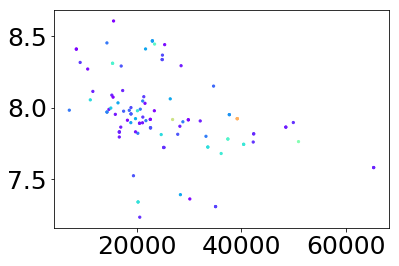

In [230]:
plt.scatter(wdtable['spec_Teff'],wdtable['spec_logg'], s = 5, c = wdtable['S/N'], vmax = 100, cmap = 'rainbow')

In [231]:
interpfluxs = [];
sigs = [];
lamgrid = np.arange(4000,8000)
for i in tqdm(range(len(wdtable))):
    spec = get_spectrum(wdtable['source_id'][i])
    lam  = spec[0]
    flux = spec[1]
    sig = spec[2]
    func2 = interp1d(lam,sig,kind='linear',assume_sorted = False,fill_value='extrapolate')
    interpsig = func2(lamgrid)
    #trans = ((wdtable['center_b'][i] - hbeta)+(wdtable['center_a'][i]-halpha))/2
    #shiftedflux = interpolation.shift(flux,-trans,cval=np.nan)
    func = interp1d(lam,flux,kind='linear',assume_sorted = False,fill_value='extrapolate')
    interpflux = func(lamgrid)
    interpfluxs.append(interpflux)
    sigs.append(interpsig)













  0%|          | 0/105 [00:00<?, ?it/s]











  2%|▏         | 2/105 [00:00<00:09, 11.25it/s]











  4%|▍         | 4/105 [00:00<00:08, 11.39it/s]











  6%|▌         | 6/105 [00:00<00:08, 11.85it/s]











  8%|▊         | 8/105 [00:00<00:08, 12.04it/s]











 10%|▉         | 10/105 [00:00<00:07, 12.46it/s]











 11%|█▏        | 12/105 [00:00<00:07, 12.52it/s]











 13%|█▎        | 14/105 [00:01<00:07, 12.42it/s]











 15%|█▌        | 16/105 [00:01<00:07, 12.67it/s]











 17%|█▋        | 18/105 [00:01<00:07, 12.25it/s]











 19%|█▉        | 20/105 [00:01<00:06, 12.55it/s]











 21%|██        | 22/105 [00:01<00:06, 12.44it/s]











 23%|██▎       | 24/105 [00:01<00:06, 12.08it/s]











 25%|██▍       | 26/105 [00:02<00:06, 12.07it/s]











 27%|██▋       | 28/105 [00:02<00:06, 12.34it/s]











 29%|██▊       | 30/105 [00:02<00:06, 12.42it/s]











 30%|███       | 32/105 [00:02<00:05, 12.

In [232]:
spectra = np.asarray(interpfluxs)
sigs = np.asarray(sigs)
lamgrid = np.arange(4000,8000)

CPU times: user 63.8 ms, sys: 2.38 ms, total: 66.2 ms
Wall time: 17.7 ms


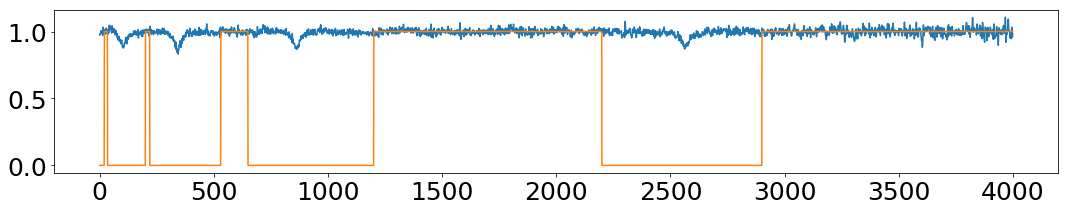

In [233]:
%%time
plt.figure(figsize=(18,3))
plt.plot(adapted_ch_cont(spectra[24],continuum))
plt.plot(continuum)

In [234]:
wdtable['spectrum'] = spectra
wdtable['ivar'] = sigs

In [235]:
clamgrid = np.linspace(4000,7000,3000)

In [236]:
norms = [norm_dataspec(np.asarray(wdtable['spectrum'][ii]),np.asarray(wdtable['ivar'][ii])) for ii in range(len(wdtable))]
wdtable['normspectrum'] = np.asarray(norms)[:,0]
wdtable['normivar'] = np.asarray(norms)[:,0]

# Fitting

#### Evaluate NFev

### Evaluate on Synthetics

### Test on Model Spectra

### Fit SDSS

### MCMC Fitting

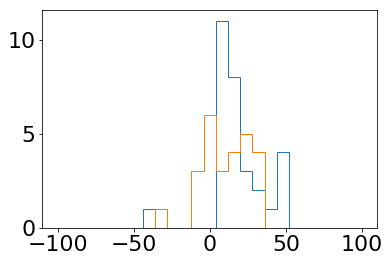

In [63]:
plt.hist(1e5*(wdtable['centre_beta']-hbeta)/hbeta, range = (-100,100), histtype = 'step', bins = 25);
plt.hist(1e5*(wdtable['centre_alpha']-halpha)/halpha, range = (-100,100), histtype = 'step', bins = 25);

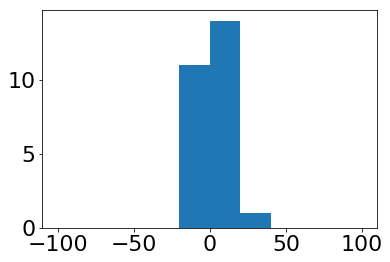

In [64]:
plt.hist((1e5*(wdtable['centre_beta']-hbeta)/hbeta) - (1e5*(wdtable['centre_alpha']-halpha)/halpha), range = (-100,100));

In [29]:
50e-5 * hbeta

2.43134

In [30]:
%%timeit

norm_spectrum_sampler(lamgrid,15000,8.,0)

838 µs ± 49.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [35]:
%%timeit 

spectrum_sampler(lamgrid,15000,8.,0)

901 µs ± 23.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [44]:
%%timeit

msc.inverse_transform(model.predict(sc.transform(np.asarray([15000,8]).reshape(-1,1).T)))

375 µs ± 15.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [54]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

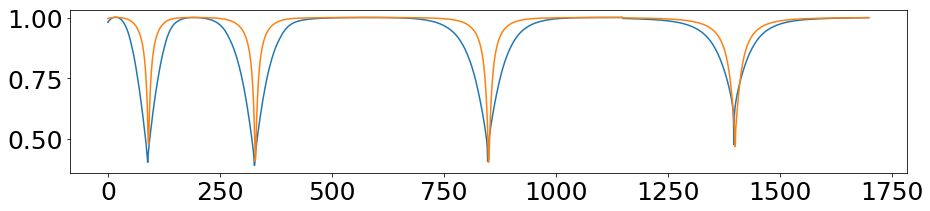

In [233]:
plt.figure(figsize = (15,3))
plt.plot(normspec)
plt.plot(spectrum_sampler(lamgrid,8190,8.2,0.13)[lines])

In [70]:
lnlike([8190,8.2,0.13])

-17855.240332626603

In [267]:
wdtable

white_dwarf_name_1_1,designation,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,astrometric_excess_noise,astrometric_sigma5d_max,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,l,b,density_1,AG_1,SDSS_name_1_1,umag_1_1,e_umag_1_1,gmag_1_1,e_gmag_1_1,rmag_1_1,e_rmag_1_1,imag_1_1,e_imag_1_1,zmag_1_1,e_zmag_1_1,test_Pwd_1,Pwd_flag_1,Teff,eTeff_1,log_g,elog_g_1,mass_1,emass_1,chi2_1,Teff_He_1,eTeff_He_1,log_g_He_1,elog_g_He_1,mass_He_1,emass_He_1,chisq_He_1,white_dwarf_name_2_1,SDSS_name_2_1,SDSS_ra_1,SDSS_dec_1,umag_2_1,e_umag_2_1,gmag_2_1,e_gmag_2_1,rmag_2_1,e_rmag_2_1,imag_2_1,e_imag_2_1,zmag_2_1,e_zmag_2_1,Plate_1,mjd_1,fiberID_1,S/N,spectral_class,specpath,specnames,sigma_a,h3_a,h4_a,ghscale_a,ghcentre_a,sigma_b,h3_b,h4_b,ghscale_b,ghcentre_b,new_bbteff,bbteff,class [1],subclass [1],goodness [1],lgamma_alpha,ggamma_alpha,centre_alpha,scale_alpha,lgamma_beta,ggamma_beta,centre_beta,scale_beta,solution_id,designation_1,random_index,ref_epoch,ra_1,ra_error_1,dec_1,dec_error_1,parallax_1,parallax_error_1,parallax_over_error,pmra_1,pmra_error_1,pmdec_1,pmdec_error_1,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise_1,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max_1,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux_1,phot_g_mean_flux_error_1,phot_g_mean_flux_over_error,phot_g_mean_mag_1,phot_bp_n_obs,phot_bp_mean_flux_1,phot_bp_mean_flux_error_1,phot_bp_mean_flux_over_error,phot_bp_mean_mag_1,phot_rp_n_obs,phot_rp_mean_flux_1,phot_rp_mean_flux_error_1,phot_rp_mean_flux_over_error,phot_rp_mean_mag_1,phot_bp_rp_excess_factor_1,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l_1,b_1,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,u_mag,g_mag,r_mag,i_mag,z_mag,w1mpro,w2mpro,cc_flags,var_flag,j_m,h_m,ks_m,g,abs_g,unit_error,Amp,var_metric_v0,var_metric_v1,abs_sdss_u,abs_sdss_g,abs_sdss_r,abs_sdss_i,abs_sdss_z,abs_w1,abs_w2,abs_j,abs_h,abs_ks,dg,N_spectra,Ha_L_gamma,Ha_L_line_wl,Ha_L_scale,Ha_L_asymmetry_500,Ha_L_asymmetry_1000,Ha_L_asymmetry_2000,Hb_L_gamma,Hb_L_line_wl,Hb_L_scale,Hb_L_asymmetry_500,Hb_L_asymmetry_1000,Hb_L_asymmetry_2000,Ha_asymmetry_500,Ha_asymmetry_1000,Ha_asymmetry_2000,Hb_asymmetry_500,Hb_asymmetry_1000,Hb_asymmetry_2000,usable_spec_count,Ha_vel_diff,Hb_vel_diff,gamma_ratio,tan_velocity,Ha_gamma_d,Ha_scale_d,Hb_gamma_d,Hb_scale_d,N_spec_to_calculate_median_lineprop,Hea_L_gamma,Hea_L_line_wl,Hea_L_scale,Hea_asymmetry_500,Hea_asymmetry_1000,Hea_asymmetry_2000,Heb_L_gamma,Heb_L_line_wl,Heb_L_scale,Heb_asymmetry_500,Heb_asymmetry_1000,Heb_asymmetry_2000,He_usable_spec_count,Sp,WD,Source,RA_ICRS,DE_ICRS,Plx,pmRA,pmDE,Gmag,BPmag,RPmag,SDSS,umag,gmag_lc,rmag,imag,zmag,Pwd,TeffH,loggH,MassH,TeffHe,loggHe,MassHe,_RA_icrs,_DE_icrs,goodflag,white_dwarf_name_1_2,designation_2,ra_2,ra_error_2,dec_2,dec_error_2,parallax_2,parallax_error_2,pmra_2,pmra_error_2,pmdec_2,pmdec_error_2,astrometric_excess_noise_2,ast

In [268]:
teffgrid = np.linspace(6000,80000,100)
logggrid = np.linspace(6.5,9.5,100)
from itertools import product

searchgrid = (np.vstack((product(teffgrid,logggrid)  )))

In [269]:
results = [];
for ii in tqdm(range(len(wdtable))):
    
    spec = wdtable['spectrum'][ii]
    sig = wdtable['ivar'][ii]
    normspec,normsig = norm_dataspec(spec,sig)
    normspec = np.asarray(normspec[lines])
    normsig = np.asarray(normsig[lines])
    def lnlike(prms):
        ivar = normsig
        model = norm_spectrum_sampler(lamgrid,prms[0],prms[1],prms[2])
        diff = model - normspec
        
#         plt.plot(model)
#         plt.plot(normspec)
#         plt.plot(diff)
        
        diff = diff[~np.isnan(model)]
        ivar = ivar[~np.isnan(model)]
        chisq = np.sum(diff**2 * ivar)
        lnlike = -0.5 * chisq
    #     plt.plot(model)
    #     plt.plot(normspec)
        return lnlike

    def lnprior(prms):
        if prms[0] < 6000 or prms[0] > 80000:
            return -np.Inf
        elif prms[1] < 6.5 or prms[1] > 9.5:
            return -np.Inf
        elif prms[2] < -3 or prms[2] > 3:
            return -np.Inf

        return 0

    def lnprob(prms):
        lp = lnprior(prms)
        if not np.isfinite(lp):
            return -np.Inf
        return lp + lnlike(prms)


    ndim,nwalkers = 3,30


    steps = 25
    burn_step = 25
    total_burned = 0
        

    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,threads = 1)
    
    acorrtime = 1e5
    #Initialize sampler
    print('Finding MLE Point...')
    
    mlept = [15000,8.]
    maxlik = -1e10
    for searchpoint in searchgrid:
        lik = lnlike([searchpoint[0],searchpoint[1],0])
        if lik > maxlik:
            mlept = searchpoint;
            maxlik = lik
            
    print('MLE Gridpoint: %i K, %.2f dex'%(mlept[0],mlept[1]))
    mlpt = np.asarray([mlept[0],mlept[1],0])
    pos1 = np.zeros((nwalkers,ndim))
    ballsigmas = [500, 0.1, 0.05]
    for jj in range(ndim):
        pos1[:,jj] = (mlpt[jj] + ballsigmas[jj] * np.random.randn(nwalkers))
    

    
    b = sampler.run_mcmc(pos1,1) #Initialize
    
    while acorrtime > (0.1 * total_burned):
        print('Burning in %i samples... (%i done)'%(burn_step,total_burned))
        b = sampler.run_mcmc(b[0],burn_step)
        total_burned = total_burned + burn_step
        try:
            acorr_teff = emcee.autocorr.function(sampler.chain[0][:,0])
            acorrtime_teff = np.argmax(acorr_teff < (1/np.exp(1)))
            acorr_logg = emcee.autocorr.function(sampler.chain[0][:,1])
            acorrtime_logg = np.argmax(acorr_logg < (1/np.exp(1)))
            acorrtime = np.mean([acorrtime_teff, acorrtime_logg])
            print('Autocorr Time = %i samples.'%int(acorrtime))
        except :
            print('Chain too short.')
            continue;
            
        if (total_burned > 1000) and (acorrtime != 1e5):
            print('Maximum burn time reached.')
            break;
    
    print('Burn-in terminated with correlation fraction = %.2f'%(acorrtime/total_burned))
    
    n_draws = np.max([acorrtime, 100]) 
    print('Sampling %i draws from posterior'%n_draws)
    
    sampler.reset()
    s = sampler.run_mcmc(b[0],int(n_draws))
    values = np.median(sampler.flatchain,0)
    meanvalues = np.mean(sampler.flatchain,0)
    modevalues = stats.mode(sampler.flatchain,0)[0]
    mlevalues = sampler.flatchain[np.argmax(sampler.flatlnprobability)]
    chi2 = -2*lnlike(mlevalues)
    lower = np.quantile(sampler.flatchain,.3173,axis=0)
    upper = np.quantile(sampler.flatchain,.6827,axis=0)
    std = np.std(sampler.flatchain,axis=0)
    
    results.append([values, meanvalues, modevalues, mlevalues, lower, upper, std, chi2])
    
    fig,axs = plt.subplots(2,2,figsize=(10,10))
    f = corner.corner(sampler.flatchain[:,0:2],show_titles = True,smooth = 0,truths = (mlevalues[0],\
            mlevalues[1]),labels = ('$T_{\mathrm{eff}}$','$\log{g}$'),title_kwargs={'fontsize':18}, fig = fig)
    plt.savefig('plots/synthmc/'+str(wdtable[ii]['source_id'])+'_corner.pdf')
    plt.close()
    plt.figure(figsize = (15,5))
    plt.title('SDSS '+str(wdtable[ii]['SDSS_name_1_1']))
    plt.plot(normspec,'k', label = 'Data Spectrum')
    plt.plot(norm_spectrum_sampler(lamgrid,mlevalues[0],mlevalues[1],mlevalues[2]),'r',\
             label = 'Fitted Synthetic',linewidth=2)
    #plt.legend()
    plt.savefig('plots/synthmc/'+str(wdtable[ii]['source_id'])+'_fit.pdf')
    plt.close()














  0%|          | 0/105 [00:00<?, ?it/s]

Finding MLE Point...
MLE Gridpoint: 28424 K, 7.95 dex
Burning in 25 samples... (0 done)
Autocorr Time = 2 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















  1%|          | 1/105 [00:12<22:17, 12.86s/it]

Finding MLE Point...
MLE Gridpoint: 23191 K, 8.50 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 4 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















  2%|▏         | 2/105 [00:26<22:16, 12.98s/it]

Finding MLE Point...
MLE Gridpoint: 23191 K, 8.50 dex
Burning in 25 samples... (0 done)
Autocorr Time = 2 samples.
Burn-in terminated with correlation fraction = 0.08
Sampling 100 draws from posterior















  3%|▎         | 3/105 [00:39<22:02, 12.97s/it]

Finding MLE Point...
MLE Gridpoint: 23191 K, 8.50 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 5 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 6 samples.
Burn-in terminated with correlation fraction = 0.08
Sampling 100 draws from posterior















  4%|▍         | 4/105 [00:53<22:24, 13.31s/it]

Finding MLE Point...
MLE Gridpoint: 20202 K, 7.86 dex
Burning in 25 samples... (0 done)
Autocorr Time = 4 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 7 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 9 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















  5%|▍         | 5/105 [01:07<22:50, 13.71s/it]

Finding MLE Point...
MLE Gridpoint: 25434 K, 7.83 dex
Burning in 25 samples... (0 done)
Autocorr Time = 2 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















  6%|▌         | 6/105 [01:20<21:59, 13.32s/it]

Finding MLE Point...
MLE Gridpoint: 25434 K, 7.83 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 9 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 14 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 15 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 16 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 16 samples.
Burning in 25 samples... (150 done)
Autocorr Time = 15 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















  7%|▋         | 7/105 [01:37<23:52, 14.62s/it]

Finding MLE Point...
MLE Gridpoint: 25434 K, 7.83 dex
Burning in 25 samples... (0 done)
Autocorr Time = 5 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 9 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 12 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 17 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 24 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 24 samples.
Burning in 25 samples... (150 done)
Autocorr Time = 23 samples.
Burning in 25 samples... (175 done)
Autocorr Time = 22 samples.
Burning in 25 samples... (200 done)
Autocorr Time = 22 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















  8%|▊         | 8/105 [01:57<25:55, 16.03s/it]

Finding MLE Point...
MLE Gridpoint: 27676 K, 7.44 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 6 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 6 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















  9%|▊         | 9/105 [02:11<24:49, 15.51s/it]

Finding MLE Point...
MLE Gridpoint: 32161 K, 7.71 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 6 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 10 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 13 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 15 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 25 samples.
Burning in 25 samples... (150 done)
Autocorr Time = 27 samples.
Burning in 25 samples... (175 done)
Autocorr Time = 27 samples.
Burning in 25 samples... (200 done)
Autocorr Time = 27 samples.
Burning in 25 samples... (225 done)
Autocorr Time = 26 samples.
Burning in 25 samples... (250 done)
Autocorr Time = 26 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 10%|▉         | 10/105 [02:32<27:05, 17.11s/it]

Finding MLE Point...
MLE Gridpoint: 24686 K, 8.26 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 9 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 14 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 13 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 14 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 15 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 10%|█         | 11/105 [02:49<26:55, 17.19s/it]

Finding MLE Point...
MLE Gridpoint: 24686 K, 8.26 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 4 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 11%|█▏        | 12/105 [03:03<25:16, 16.31s/it]

Finding MLE Point...
MLE Gridpoint: 20202 K, 7.98 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 10 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 11 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 12 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 13 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 13 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 12%|█▏        | 13/105 [03:20<25:09, 16.40s/it]

Finding MLE Point...
MLE Gridpoint: 20202 K, 8.35 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 7 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 11 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 14 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 15 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 18 samples.
Burning in 25 samples... (150 done)
Autocorr Time = 19 samples.
Burning in 25 samples... (175 done)
Autocorr Time = 20 samples.
Burning in 25 samples... (200 done)
Autocorr Time = 22 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 13%|█▎        | 14/105 [03:39<25:56, 17.10s/it]

Finding MLE Point...
MLE Gridpoint: 15717 K, 7.92 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 6 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 9 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 10 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 14%|█▍        | 15/105 [03:54<24:38, 16.43s/it]

Finding MLE Point...
MLE Gridpoint: 32909 K, 7.68 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 10 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 11 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 11 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 15%|█▌        | 16/105 [04:10<24:26, 16.48s/it]

Finding MLE Point...
MLE Gridpoint: 32909 K, 7.68 dex
Burning in 25 samples... (0 done)
Autocorr Time = 4 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 7 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 16%|█▌        | 17/105 [04:26<23:39, 16.13s/it]

Finding MLE Point...
MLE Gridpoint: 29171 K, 7.26 dex
Burning in 25 samples... (0 done)
Autocorr Time = 4 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 6 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 6 samples.
Burn-in terminated with correlation fraction = 0.08
Sampling 100 draws from posterior















 17%|█▋        | 18/105 [04:40<22:37, 15.60s/it]

Finding MLE Point...
MLE Gridpoint: 23191 K, 8.14 dex
Burning in 25 samples... (0 done)
Autocorr Time = 6 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 10 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 12 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 13 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 13 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 13 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 18%|█▊        | 19/105 [05:00<24:21, 17.00s/it]

Finding MLE Point...
MLE Gridpoint: 53090 K, 7.89 dex
Burning in 25 samples... (0 done)
Autocorr Time = 4 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 7 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 7 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 19%|█▉        | 20/105 [05:16<23:36, 16.66s/it]

Finding MLE Point...
MLE Gridpoint: 8242 K, 8.47 dex
Burning in 25 samples... (0 done)
Autocorr Time = 5 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 9 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 20%|██        | 21/105 [05:34<23:54, 17.08s/it]

Finding MLE Point...
MLE Gridpoint: 8242 K, 8.47 dex
Burning in 25 samples... (0 done)
Autocorr Time = 2 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 21%|██        | 22/105 [05:51<23:28, 16.97s/it]

Finding MLE Point...
MLE Gridpoint: 20949 K, 8.14 dex
Burning in 25 samples... (0 done)
Autocorr Time = 2 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 22%|██▏       | 23/105 [06:05<22:12, 16.26s/it]

Finding MLE Point...
MLE Gridpoint: 67292 K, 7.68 dex
Burning in 25 samples... (0 done)
Autocorr Time = 2 samples.
Burn-in terminated with correlation fraction = 0.08
Sampling 100 draws from posterior















 23%|██▎       | 24/105 [06:20<21:12, 15.71s/it]

Finding MLE Point...
MLE Gridpoint: 67292 K, 7.68 dex
Burning in 25 samples... (0 done)
Autocorr Time = 4 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 7 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 9 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 11 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 11 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 24%|██▍       | 25/105 [06:37<21:35, 16.19s/it]

Finding MLE Point...
MLE Gridpoint: 27676 K, 7.95 dex
Burning in 25 samples... (0 done)
Autocorr Time = 4 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 6 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 10 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 10 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 11 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 25%|██▍       | 26/105 [06:55<21:59, 16.70s/it]

Finding MLE Point...
MLE Gridpoint: 14222 K, 7.77 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 6 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 11 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 14 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 17 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 19 samples.
Burning in 25 samples... (150 done)
Autocorr Time = 20 samples.
Burning in 25 samples... (175 done)
Autocorr Time = 22 samples.
Burning in 25 samples... (200 done)
Autocorr Time = 23 samples.
Burning in 25 samples... (225 done)
Autocorr Time = 23 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 26%|██▌       | 27/105 [07:18<24:09, 18.58s/it]

Finding MLE Point...
MLE Gridpoint: 27676 K, 7.95 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 6 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 10 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 11 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 18 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 19 samples.
Burning in 25 samples... (150 done)
Autocorr Time = 18 samples.
Burning in 25 samples... (175 done)
Autocorr Time = 17 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 27%|██▋       | 28/105 [07:38<24:30, 19.10s/it]

Finding MLE Point...
MLE Gridpoint: 6747 K, 8.14 dex
Burning in 25 samples... (0 done)
Autocorr Time = 6 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 10 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 14 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 16 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 19 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 20 samples.
Burning in 25 samples... (150 done)
Autocorr Time = 20 samples.
Burning in 25 samples... (175 done)
Autocorr Time = 19 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 28%|██▊       | 29/105 [07:59<24:44, 19.54s/it]

Finding MLE Point...
MLE Gridpoint: 8989 K, 8.65 dex
Burning in 25 samples... (0 done)
Autocorr Time = 4 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 10 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 11 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 12 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 29%|██▊       | 30/105 [08:16<23:37, 18.91s/it]

Finding MLE Point...
MLE Gridpoint: 23939 K, 8.05 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 6 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 9 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 16 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 18 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 18 samples.
Burning in 25 samples... (150 done)
Autocorr Time = 19 samples.
Burning in 25 samples... (175 done)
Autocorr Time = 20 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 30%|██▉       | 31/105 [08:36<23:40, 19.20s/it]

Finding MLE Point...
MLE Gridpoint: 23939 K, 8.05 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 12 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 11 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 30%|███       | 32/105 [08:54<22:45, 18.70s/it]

Finding MLE Point...
MLE Gridpoint: 26181 K, 8.20 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 3 samples.
Burn-in terminated with correlation fraction = 0.07
Sampling 100 draws from posterior















 31%|███▏      | 33/105 [09:09<21:05, 17.58s/it]

Finding MLE Point...
MLE Gridpoint: 11232 K, 8.29 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 5 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 7 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 32%|███▏      | 34/105 [09:24<20:03, 16.96s/it]

Finding MLE Point...
MLE Gridpoint: 18707 K, 7.26 dex
Burning in 25 samples... (0 done)
Autocorr Time = 5 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 6 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 9 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 33%|███▎      | 35/105 [09:41<19:32, 16.75s/it]

Finding MLE Point...
MLE Gridpoint: 18707 K, 7.26 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 12 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 13 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 14 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 22 samples.
Burning in 25 samples... (150 done)
Autocorr Time = 22 samples.
Burning in 25 samples... (175 done)
Autocorr Time = 22 samples.
Burning in 25 samples... (200 done)
Autocorr Time = 22 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 34%|███▍      | 36/105 [10:03<21:12, 18.44s/it]

Finding MLE Point...
MLE Gridpoint: 19454 K, 7.95 dex
Burning in 25 samples... (0 done)
Autocorr Time = 4 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 9 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 15 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 15 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 15 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 16 samples.
Burning in 25 samples... (150 done)
Autocorr Time = 15 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 35%|███▌      | 37/105 [10:23<21:31, 19.00s/it]

Finding MLE Point...
MLE Gridpoint: 35151 K, 7.26 dex
Burning in 25 samples... (0 done)
Autocorr Time = 4 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 7 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 9 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 36%|███▌      | 38/105 [10:40<20:18, 18.19s/it]

Finding MLE Point...
MLE Gridpoint: 35151 K, 7.26 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 4 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 37%|███▋      | 39/105 [10:54<18:54, 17.19s/it]

Finding MLE Point...
MLE Gridpoint: 16464 K, 7.80 dex
Burning in 25 samples... (0 done)
Autocorr Time = 4 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 5 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 38%|███▊      | 40/105 [11:10<18:08, 16.74s/it]

Finding MLE Point...
MLE Gridpoint: 23191 K, 8.47 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 11 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 16 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 18 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 18 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 19 samples.
Burning in 25 samples... (150 done)
Autocorr Time = 19 samples.
Burning in 25 samples... (175 done)
Autocorr Time = 19 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 39%|███▉      | 41/105 [11:30<18:45, 17.58s/it]

Finding MLE Point...
MLE Gridpoint: 18707 K, 7.95 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 10 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 14 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 18 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 18 samples.
Burning in 25 samples... (150 done)
Autocorr Time = 14 samples.
Burn-in terminated with correlation fraction = 0.08
Sampling 100 draws from posterior















 40%|████      | 42/105 [11:47<18:26, 17.57s/it]

Finding MLE Point...
MLE Gridpoint: 18707 K, 7.95 dex
Burning in 25 samples... (0 done)
Autocorr Time = 4 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 5 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 6 samples.
Burn-in terminated with correlation fraction = 0.08
Sampling 100 draws from posterior















 41%|████      | 43/105 [12:02<17:27, 16.90s/it]

Finding MLE Point...
MLE Gridpoint: 10484 K, 8.38 dex
Burning in 25 samples... (0 done)
Autocorr Time = 4 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 6 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 9 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 11 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 12 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 42%|████▏     | 44/105 [12:19<16:55, 16.65s/it]

Finding MLE Point...
MLE Gridpoint: 16464 K, 8.05 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 6 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 7 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 43%|████▎     | 45/105 [12:34<16:11, 16.19s/it]

Finding MLE Point...
MLE Gridpoint: 44121 K, 7.77 dex
Burning in 25 samples... (0 done)
Autocorr Time = 4 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 9 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 11 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 14 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 17 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 17 samples.
Burning in 25 samples... (150 done)
Autocorr Time = 16 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 44%|████▍     | 46/105 [12:52<16:25, 16.71s/it]

Finding MLE Point...
MLE Gridpoint: 38888 K, 8.17 dex
Burning in 25 samples... (0 done)
Autocorr Time = 6 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 10 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 11 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 12 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 45%|████▍     | 47/105 [13:08<16:03, 16.60s/it]

Finding MLE Point...
MLE Gridpoint: 38888 K, 8.17 dex
Burning in 25 samples... (0 done)
Autocorr Time = 5 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 8 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 46%|████▌     | 48/105 [13:23<15:26, 16.26s/it]

Finding MLE Point...
MLE Gridpoint: 41131 K, 7.74 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 10 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 10 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 11 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 12 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 47%|████▋     | 49/105 [13:40<15:10, 16.25s/it]

Finding MLE Point...
MLE Gridpoint: 41131 K, 7.74 dex
Burning in 25 samples... (0 done)
Autocorr Time = 5 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 11 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 13 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 15 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 15 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 14 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 48%|████▊     | 50/105 [13:57<15:05, 16.46s/it]

Finding MLE Point...
MLE Gridpoint: 41131 K, 7.74 dex
Burning in 25 samples... (0 done)
Autocorr Time = 5 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 10 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 11 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 11 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 11 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 49%|████▊     | 51/105 [14:13<14:51, 16.51s/it]

Finding MLE Point...
MLE Gridpoint: 25434 K, 8.47 dex
Burning in 25 samples... (0 done)
Autocorr Time = 2 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 50%|████▉     | 52/105 [14:27<13:44, 15.55s/it]

Finding MLE Point...
MLE Gridpoint: 19454 K, 7.83 dex
Burning in 25 samples... (0 done)
Autocorr Time = 4 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 6 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 6 samples.
Burn-in terminated with correlation fraction = 0.08
Sampling 100 draws from posterior















 50%|█████     | 53/105 [14:41<13:16, 15.32s/it]

Finding MLE Point...
MLE Gridpoint: 14222 K, 7.86 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 9 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 10 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 51%|█████▏    | 54/105 [14:57<13:07, 15.45s/it]

Finding MLE Point...
MLE Gridpoint: 23939 K, 8.11 dex
Burning in 25 samples... (0 done)
Autocorr Time = 1 samples.
Burn-in terminated with correlation fraction = 0.06
Sampling 100 draws from posterior















 52%|█████▏    | 55/105 [15:10<12:20, 14.81s/it]

Finding MLE Point...
MLE Gridpoint: 23939 K, 8.11 dex
Burning in 25 samples... (0 done)
Autocorr Time = 4 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 4 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 53%|█████▎    | 56/105 [15:24<11:53, 14.56s/it]

Finding MLE Point...
MLE Gridpoint: 23939 K, 8.11 dex
Burning in 25 samples... (0 done)
Autocorr Time = 2 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 54%|█████▍    | 57/105 [15:38<11:19, 14.15s/it]

Finding MLE Point...
MLE Gridpoint: 14969 K, 8.59 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 12 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 18 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 22 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 24 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 26 samples.
Burning in 25 samples... (150 done)
Autocorr Time = 28 samples.
Burning in 25 samples... (175 done)
Autocorr Time = 28 samples.
Burning in 25 samples... (200 done)
Autocorr Time = 28 samples.
Burning in 25 samples... (225 done)
Autocorr Time = 28 samples.
Burning in 25 samples... (250 done)
Autocorr Time = 28 samples.
Burning in 25 samples... (275 done)
Autocorr Time = 28 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 55%|█████▌    | 58/105 [15:59<12:45, 16.30s/it]

Finding MLE Point...
MLE Gridpoint: 33656 K, 8.59 dex
Burning in 25 samples... (0 done)
Autocorr Time = 4 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 9 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 13 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 13 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 13 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 13 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 56%|█████▌    | 59/105 [16:16<12:37, 16.46s/it]

Finding MLE Point...
MLE Gridpoint: 35898 K, 7.71 dex
Burning in 25 samples... (0 done)
Autocorr Time = 5 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 12 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 15 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 20 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 22 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 22 samples.
Burning in 25 samples... (150 done)
Autocorr Time = 22 samples.
Burning in 25 samples... (175 done)
Autocorr Time = 21 samples.
Burning in 25 samples... (200 done)
Autocorr Time = 21 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 57%|█████▋    | 60/105 [16:36<13:07, 17.50s/it]

Finding MLE Point...
MLE Gridpoint: 43373 K, 7.92 dex
Burning in 25 samples... (0 done)
Autocorr Time = 2 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 58%|█████▊    | 61/105 [16:50<12:13, 16.66s/it]

Finding MLE Point...
MLE Gridpoint: 43373 K, 7.92 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 6 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 6 samples.
Burn-in terminated with correlation fraction = 0.08
Sampling 100 draws from posterior















 59%|█████▉    | 62/105 [17:05<11:34, 16.14s/it]

Finding MLE Point...
MLE Gridpoint: 26181 K, 7.89 dex
Burning in 25 samples... (0 done)
Autocorr Time = 1 samples.
Burn-in terminated with correlation fraction = 0.06
Sampling 100 draws from posterior















 60%|██████    | 63/105 [17:18<10:35, 15.14s/it]

Finding MLE Point...
MLE Gridpoint: 50101 K, 7.80 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 4 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 61%|██████    | 64/105 [17:31<09:57, 14.58s/it]

Finding MLE Point...
MLE Gridpoint: 50101 K, 7.80 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 7 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 14 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 19 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 20 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 15 samples.
Burning in 25 samples... (150 done)
Autocorr Time = 18 samples.
Burning in 25 samples... (175 done)
Autocorr Time = 18 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 62%|██████▏   | 65/105 [17:49<10:16, 15.42s/it]

Finding MLE Point...
MLE Gridpoint: 19454 K, 7.83 dex
Burning in 25 samples... (0 done)
Autocorr Time = 5 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 7 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 63%|██████▎   | 66/105 [18:03<09:43, 14.97s/it]

Finding MLE Point...
MLE Gridpoint: 16464 K, 8.08 dex
Burning in 25 samples... (0 done)
Autocorr Time = 6 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 9 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 9 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 64%|██████▍   | 67/105 [18:18<09:29, 14.99s/it]

Finding MLE Point...
MLE Gridpoint: 14222 K, 8.26 dex
Burning in 25 samples... (0 done)
Autocorr Time = 2 samples.
Burn-in terminated with correlation fraction = 0.08
Sampling 100 draws from posterior















 65%|██████▍   | 68/105 [18:31<08:53, 14.41s/it]

Finding MLE Point...
MLE Gridpoint: 41878 K, 7.71 dex
Burning in 25 samples... (0 done)
Autocorr Time = 2 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 66%|██████▌   | 69/105 [18:44<08:21, 13.94s/it]

Finding MLE Point...
MLE Gridpoint: 41878 K, 7.71 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 4 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 67%|██████▋   | 70/105 [18:57<08:05, 13.87s/it]

Finding MLE Point...
MLE Gridpoint: 17959 K, 7.95 dex
Burning in 25 samples... (0 done)
Autocorr Time = 2 samples.
Burn-in terminated with correlation fraction = 0.08
Sampling 100 draws from posterior















 68%|██████▊   | 71/105 [19:10<07:39, 13.51s/it]

Finding MLE Point...
MLE Gridpoint: 18707 K, 7.62 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 3 samples.
Burn-in terminated with correlation fraction = 0.07
Sampling 100 draws from posterior















 69%|██████▊   | 72/105 [19:23<07:23, 13.44s/it]

Finding MLE Point...
MLE Gridpoint: 18707 K, 7.62 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 6 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 9 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 13 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 21 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 20 samples.
Burning in 25 samples... (150 done)
Autocorr Time = 20 samples.
Burning in 25 samples... (175 done)
Autocorr Time = 22 samples.
Burning in 25 samples... (200 done)
Autocorr Time = 21 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 70%|██████▉   | 73/105 [19:41<07:55, 14.85s/it]

Finding MLE Point...
MLE Gridpoint: 54585 K, 7.80 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 4 samples.
Burn-in terminated with correlation fraction = 0.08
Sampling 100 draws from posterior















 70%|███████   | 74/105 [19:55<07:24, 14.35s/it]

Finding MLE Point...
MLE Gridpoint: 17959 K, 7.95 dex
Burning in 25 samples... (0 done)
Autocorr Time = 2 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 71%|███████▏  | 75/105 [20:08<06:58, 13.94s/it]

Finding MLE Point...
MLE Gridpoint: 24686 K, 8.44 dex
Burning in 25 samples... (0 done)
Autocorr Time = 5 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 10 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 11 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 12 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 13 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 15 samples.
Burning in 25 samples... (150 done)
Autocorr Time = 16 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 72%|███████▏  | 76/105 [20:24<07:07, 14.76s/it]

Finding MLE Point...
MLE Gridpoint: 20202 K, 7.92 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 5 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 73%|███████▎  | 77/105 [20:37<06:39, 14.28s/it]

Finding MLE Point...
MLE Gridpoint: 27676 K, 8.35 dex
Burning in 25 samples... (0 done)
Autocorr Time = 5 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 9 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 9 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 74%|███████▍  | 78/105 [20:52<06:29, 14.44s/it]

Finding MLE Point...
MLE Gridpoint: 14222 K, 8.50 dex
Burning in 25 samples... (0 done)
Autocorr Time = 4 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 5 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 75%|███████▌  | 79/105 [21:05<06:05, 14.06s/it]

Finding MLE Point...
MLE Gridpoint: 16464 K, 7.80 dex
Burning in 25 samples... (0 done)
Autocorr Time = 5 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 6 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 7 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 76%|███████▌  | 80/105 [21:19<05:49, 13.99s/it]

Finding MLE Point...
MLE Gridpoint: 20949 K, 8.14 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 7 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 9 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 10 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 77%|███████▋  | 81/105 [21:34<05:40, 14.20s/it]

Finding MLE Point...
MLE Gridpoint: 17959 K, 7.86 dex
Burning in 25 samples... (0 done)
Autocorr Time = 4 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 9 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 9 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 9 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 78%|███████▊  | 82/105 [21:49<05:29, 14.34s/it]

Finding MLE Point...
MLE Gridpoint: 31414 K, 7.86 dex
Burning in 25 samples... (0 done)
Autocorr Time = 2 samples.
Burn-in terminated with correlation fraction = 0.08
Sampling 100 draws from posterior















 79%|███████▉  | 83/105 [22:01<05:04, 13.85s/it]

Finding MLE Point...
MLE Gridpoint: 17212 K, 7.83 dex
Burning in 25 samples... (0 done)
Autocorr Time = 5 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 9 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 10 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 15 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 16 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 17 samples.
Burning in 25 samples... (150 done)
Autocorr Time = 17 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 80%|████████  | 84/105 [22:19<05:13, 14.94s/it]

Finding MLE Point...
MLE Gridpoint: 20202 K, 7.32 dex
Burning in 25 samples... (0 done)
Autocorr Time = 2 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 81%|████████  | 85/105 [22:33<04:56, 14.83s/it]

Finding MLE Point...
MLE Gridpoint: 18707 K, 7.89 dex
Burning in 25 samples... (0 done)
Autocorr Time = 5 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 7 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 7 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 82%|████████▏ | 86/105 [22:49<04:49, 15.23s/it]

Finding MLE Point...
MLE Gridpoint: 15717 K, 7.74 dex
Burning in 25 samples... (0 done)
Autocorr Time = 4 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 10 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 9 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 12 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 16 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 16 samples.
Burning in 25 samples... (150 done)
Autocorr Time = 16 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 83%|████████▎ | 87/105 [23:07<04:46, 15.90s/it]

Finding MLE Point...
MLE Gridpoint: 15717 K, 7.74 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 4 samples.
Burn-in terminated with correlation fraction = 0.08
Sampling 100 draws from posterior















 84%|████████▍ | 88/105 [23:21<04:23, 15.48s/it]

Finding MLE Point...
MLE Gridpoint: 15717 K, 7.74 dex
Burning in 25 samples... (0 done)
Autocorr Time = 4 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 6 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 11 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 11 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 11 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 85%|████████▍ | 89/105 [23:38<04:10, 15.68s/it]

Finding MLE Point...
MLE Gridpoint: 13474 K, 7.80 dex
Burning in 25 samples... (0 done)
Autocorr Time = 2 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 86%|████████▌ | 90/105 [23:50<03:42, 14.85s/it]

Finding MLE Point...
MLE Gridpoint: 13474 K, 7.80 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 4 samples.
Burn-in terminated with correlation fraction = 0.08
Sampling 100 draws from posterior















 87%|████████▋ | 91/105 [24:04<03:23, 14.55s/it]

Finding MLE Point...
MLE Gridpoint: 15717 K, 7.62 dex
Burning in 25 samples... (0 done)
Autocorr Time = 4 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 7 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 12 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 16 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 18 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 19 samples.
Burning in 25 samples... (150 done)
Autocorr Time = 19 samples.
Burning in 25 samples... (175 done)
Autocorr Time = 20 samples.
Burning in 25 samples... (200 done)
Autocorr Time = 21 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 88%|████████▊ | 92/105 [24:23<03:25, 15.82s/it]

Finding MLE Point...
MLE Gridpoint: 14222 K, 7.89 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 10 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 15 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 14 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 14 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 17 samples.
Burning in 25 samples... (150 done)
Autocorr Time = 17 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 89%|████████▊ | 93/105 [24:41<03:17, 16.45s/it]

Finding MLE Point...
MLE Gridpoint: 21696 K, 8.02 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 10 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 12 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 13 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 18 samples.
Burning in 25 samples... (150 done)
Autocorr Time = 17 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 90%|████████▉ | 94/105 [24:59<03:04, 16.78s/it]

Finding MLE Point...
MLE Gridpoint: 14969 K, 7.74 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 6 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 9 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 11 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 11 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 90%|█████████ | 95/105 [25:14<02:43, 16.32s/it]

Finding MLE Point...
MLE Gridpoint: 38141 K, 7.86 dex
Burning in 25 samples... (0 done)
Autocorr Time = 6 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 8 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 91%|█████████▏| 96/105 [25:29<02:22, 15.86s/it]

Finding MLE Point...
MLE Gridpoint: 38141 K, 7.86 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 7 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 10 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 92%|█████████▏| 97/105 [25:43<02:04, 15.51s/it]

Finding MLE Point...
MLE Gridpoint: 18707 K, 7.86 dex
Burning in 25 samples... (0 done)
Autocorr Time = 2 samples.
Burn-in terminated with correlation fraction = 0.08
Sampling 100 draws from posterior















 93%|█████████▎| 98/105 [25:57<01:44, 14.93s/it]

Finding MLE Point...
MLE Gridpoint: 17959 K, 7.44 dex
Burning in 25 samples... (0 done)
Autocorr Time = 5 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 9 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 9 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 94%|█████████▍| 99/105 [26:13<01:31, 15.18s/it]

Finding MLE Point...
MLE Gridpoint: 29919 K, 7.86 dex
Burning in 25 samples... (0 done)
Autocorr Time = 2 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 95%|█████████▌| 100/105 [26:26<01:13, 14.73s/it]

Finding MLE Point...
MLE Gridpoint: 29919 K, 7.86 dex
Burning in 25 samples... (0 done)
Autocorr Time = 4 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 6 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 8 samples.
Burn-in terminated with correlation fraction = 0.08
Sampling 100 draws from posterior















 96%|█████████▌| 101/105 [26:42<00:59, 14.94s/it]

Finding MLE Point...
MLE Gridpoint: 14969 K, 7.92 dex
Burning in 25 samples... (0 done)
Autocorr Time = 4 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 6 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 9 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 12 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 15 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 15 samples.
Burning in 25 samples... (150 done)
Autocorr Time = 15 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 97%|█████████▋| 102/105 [27:00<00:47, 15.92s/it]

Finding MLE Point...
MLE Gridpoint: 14222 K, 8.17 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 10 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 15 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 17 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 18 samples.
Burning in 25 samples... (150 done)
Autocorr Time = 19 samples.
Burning in 25 samples... (175 done)
Autocorr Time = 20 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















 98%|█████████▊| 103/105 [27:19<00:33, 16.83s/it]

Finding MLE Point...
MLE Gridpoint: 14222 K, 8.17 dex
Burning in 25 samples... (0 done)
Autocorr Time = 3 samples.
Burning in 25 samples... (25 done)
Autocorr Time = 8 samples.
Burning in 25 samples... (50 done)
Autocorr Time = 12 samples.
Burning in 25 samples... (75 done)
Autocorr Time = 13 samples.
Burning in 25 samples... (100 done)
Autocorr Time = 15 samples.
Burning in 25 samples... (125 done)
Autocorr Time = 15 samples.
Burning in 25 samples... (150 done)
Autocorr Time = 16 samples.
Burn-in terminated with correlation fraction = 0.09
Sampling 100 draws from posterior















 99%|█████████▉| 104/105 [27:37<00:17, 17.16s/it]

Finding MLE Point...
MLE Gridpoint: 25434 K, 8.14 dex
Burning in 25 samples... (0 done)
Autocorr Time = 2 samples.
Burn-in terminated with correlation fraction = 0.10
Sampling 100 draws from posterior















100%|██████████| 105/105 [27:52<00:00, 16.49s/it]

In [270]:
results = np.asarray(results)
mles = results[:,1]
lowers = results[:,4]
uppers = results[:,5]
stds = results[:,6]
chi2s = results[:,7]/(4000 - 3)

### Compare to Tremblay

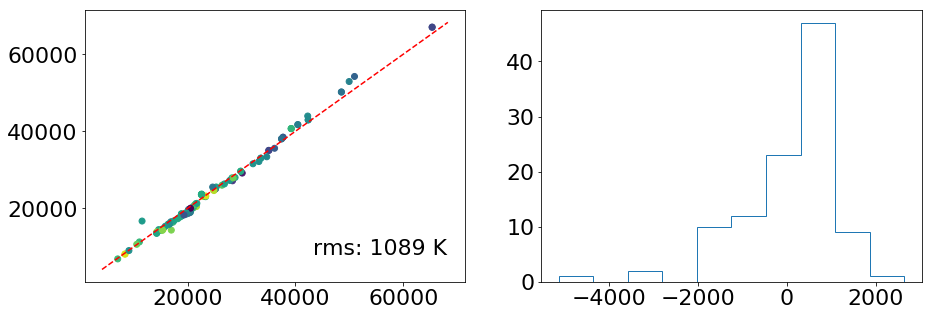

In [271]:
plt.rcParams.update({'font.size': 22})

mlespec_Teff = [i[0] for i in mles]
lowspec_Teff = [i[0] for i in stds]
highspec_Teff = [i[0] for i in stds]
plt.figure(figsize=(15,5))
plt.subplot(121)
resid = wdtable['spec_Teff'][0:len(mles)]-mlespec_Teff
rms = np.sqrt(np.mean(resid**2))
f = plt.scatter(wdtable['spec_Teff'][0:len(mles)],mlespec_Teff, c = wdtable['log_g'][0:len(mles)])
plt.text(0.6,0.1,'rms: %i K'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.subplot(122)
plt.hist(resid, histtype = 'step');

Text(0, 0.5, 'Fitted $T_{eff}$ (K)')

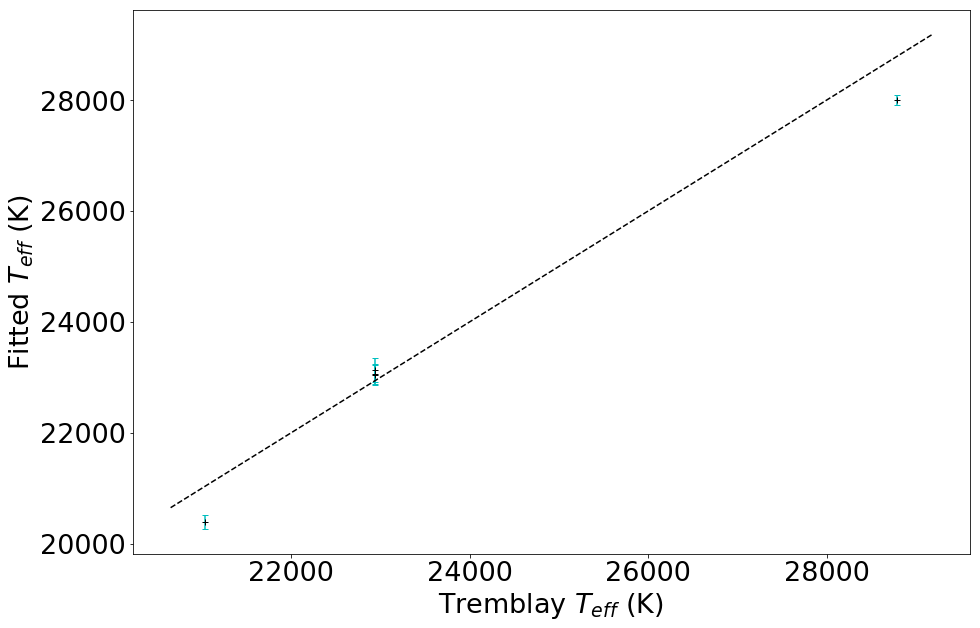

In [243]:
plt.rcParams.update({'font.size': 27})
mlespec_Teff = [i[0] for i in mles]
mask = np.asarray(mlespec_Teff) < 25000
resid = wdtable['spec_Teff'][0:len(mles)]-mlespec_Teff
rms = np.sqrt(np.mean(resid**2))
plt.figure(figsize = (15,10))
f = plt.subplot(111)
plt.errorbar(wdtable['spec_Teff'][0:len(mles)],mlespec_Teff, yerr = (lowspec_Teff,highspec_Teff), linestyle = 'None', marker = '+',\
            color = 'k', ecolor = 'c', capsize = 3)
#plt.text(0.6,0.1,'rms: %i K'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'k--')
plt.xlabel('Tremblay $T_{eff}$ (K)')
plt.ylabel('Fitted $T_{eff}$ (K)')

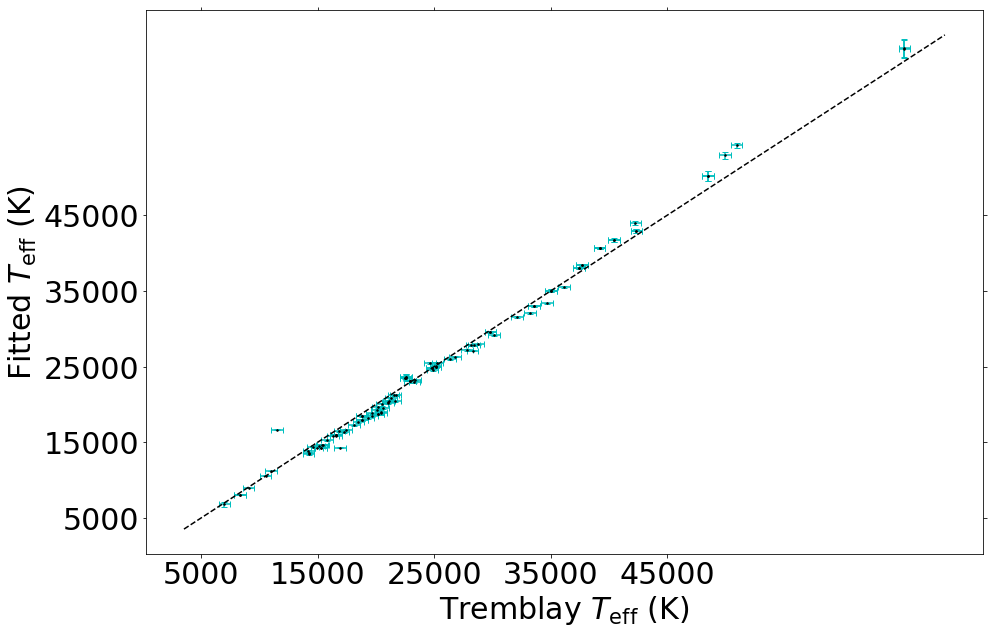

In [273]:
## REPLACE TREMBLAY ERRRORS HERE
plt.rcParams.update({'font.size': 30})
mlespec_Teff = [i[0] for i in mles]
resid = wdtable['spec_Teff'][0:len(mles)]-np.asarray(mlespec_Teff)
mask = np.asarray(mlespec_Teff)>0
rms = np.sqrt(np.mean(resid**2))
plt.figure(figsize = (15,10))
f = plt.subplot(111)
f.tick_params(top = True,right = True)
plt.errorbar(wdtable['spec_Teff'][0:len(mles)][mask],np.asarray(mlespec_Teff)[mask],\
    yerr = (np.asarray(lowspec_Teff)[mask],np.asarray(highspec_Teff)[mask]), linestyle = 'None', marker = '.',\
            color = 'k', ecolor = 'c', capsize = 3, markersize = 3,\
    xerr = (np.repeat(500,len(mask))[mask],np.repeat(500,len(mask))[mask] ))
#plt.text(0.6,0.1,'rms: %i K'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'k--')
plt.xlabel('Tremblay $T_{\mathrm{eff}}$ (K)')
plt.ylabel('Fitted $T_{\mathrm{eff}}$ (K)')
f.yaxis.set_ticks(np.arange(5000,50000,10000));
f.xaxis.set_ticks(np.arange(5000,50000,10000));
plt.savefig('teffcompare.pdf')

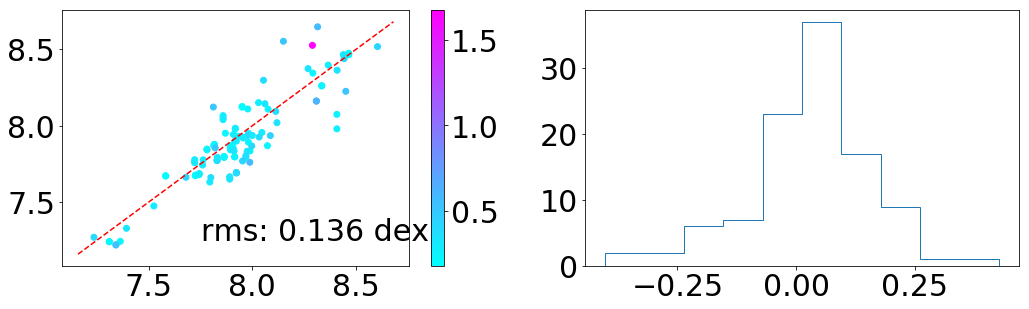

In [274]:
mlespec_logg = [i[1] for i in mles]
lowspec_logg = [i[1] for i in stds]
highspec_logg = [i[1] for i in stds]
plt.figure(figsize=(15,5))
resid = wdtable['spec_logg'][0:len(mles)]-mlespec_logg
rms = np.sqrt(np.mean(resid**2))
plt.subplot(121)
f = plt.scatter(wdtable['spec_logg'][0:len(mles)],mlespec_logg, c = chi2s, cmap = 'cool')
plt.colorbar()
plt.text(0.4,0.1,'rms: %.3f dex'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.subplot(122)
plt.hist(resid, histtype = 'step');
plt.tight_layout()

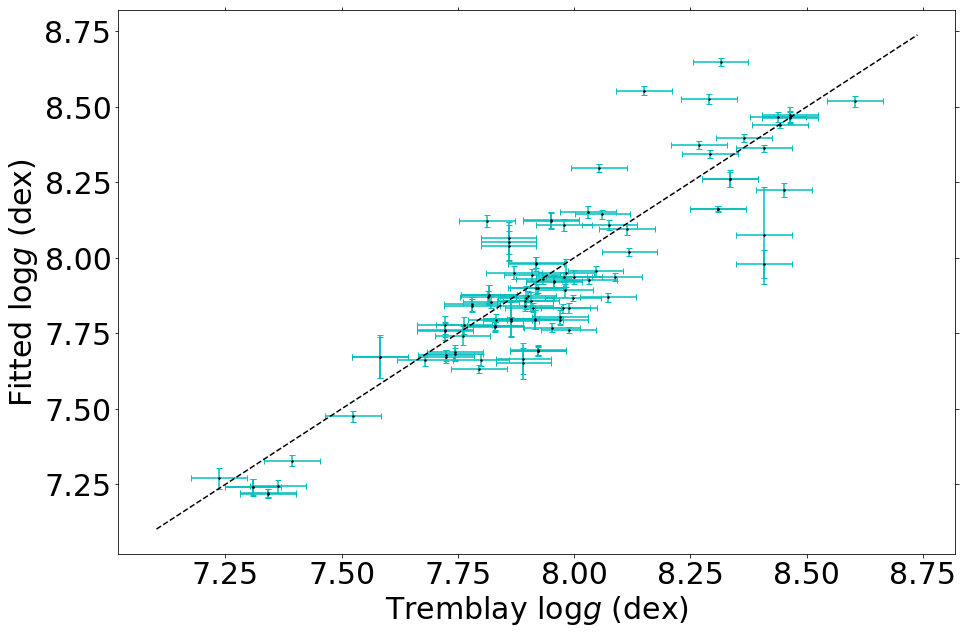

In [275]:
mlespec_logg = [i[1] for i in mles]
resid = wdtable['spec_logg'][0:len(mles)]-mlespec_logg
rms = np.sqrt(np.mean(resid**2))
plt.figure(figsize = (15,10))
f = plt.subplot(111)
plt.errorbar(wdtable['spec_logg'][0:len(mles)][mask],np.asarray(mlespec_logg)[mask], yerr = (np.asarray(lowspec_logg)[mask],np.asarray(highspec_logg)[mask]), linestyle = 'None', marker = '.',\
            color = 'k', ecolor = 'c', capsize = 3,\
            markersize= 3, xerr = (np.repeat(0.06,len(mask))[mask], np.repeat(0.06,len(mask))[mask]))
#plt.text(0.6,0.1,'rms: %.2f dex'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'k--')
plt.xlabel('Tremblay $\log{g}$ (dex)')
plt.ylabel('Fitted $\log{g}$ (dex)')
f.tick_params(top = True,right = True);
plt.savefig('logcomp.pdf')

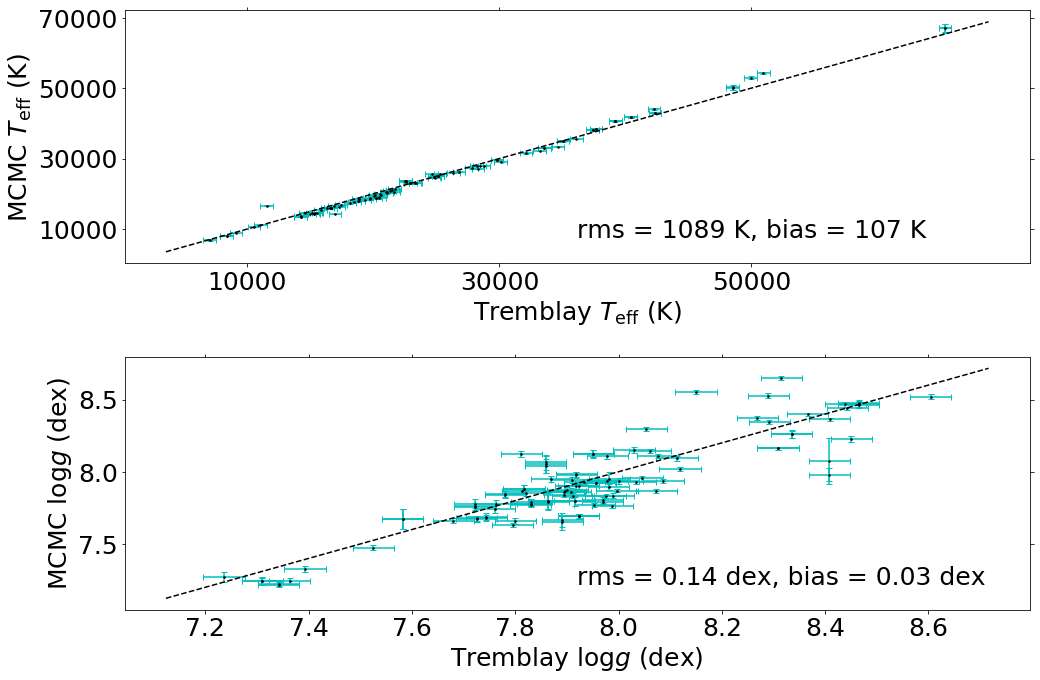

In [287]:
plt.figure(figsize = (15,10))
plt.rcParams.update({'font.size': 25})
f=plt.subplot(211)
mlespec_Teff = [i[0] for i in mles]
resid = wdtable['spec_Teff'][0:len(mles)]-np.asarray(mlespec_Teff)
mask = np.asarray(mlespec_Teff)>0
rms = np.sqrt(np.mean(resid**2))
bias = np.mean(resid)
plt.text(0.5,0.1,'rms = %i K, bias = %i K'%(rms,bias), transform = f.transAxes)
f.tick_params(top = True,right = True)
plt.errorbar(wdtable['spec_Teff'][0:len(mles)][mask],np.asarray(mlespec_Teff)[mask],\
    yerr = (np.asarray(lowspec_Teff)[mask],np.asarray(highspec_Teff)[mask]), linestyle = 'None', marker = '.',\
            color = 'k', ecolor = 'c', capsize = 3, markersize = 3,\
    xerr = (np.repeat(500,len(mask))[mask],np.repeat(500,len(mask))[mask] ))
#plt.text(0.6,0.1,'rms: %i K'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'k--')
plt.xlabel('Tremblay $T_{\mathrm{eff}}$ (K)')
plt.ylabel('MCMC $T_{\mathrm{eff}}$ (K)')
f.yaxis.set_ticks(np.arange(10000,80000,20000));
f.xaxis.set_ticks(np.arange(10000,70000,20000));

f=plt.subplot(212)
mlespec_logg = [i[1] for i in mles]
resid = wdtable['spec_logg'][0:len(mles)]-mlespec_logg
rms = np.sqrt(np.mean(resid**2))
bias = np.mean(resid)
plt.text(0.5,0.1,'rms = %.2f dex, bias = %.2f dex'%(rms,bias), transform = f.transAxes);
plt.errorbar(wdtable['spec_logg'][0:len(mles)][mask],np.asarray(mlespec_logg)[mask], yerr = (np.asarray(lowspec_logg)[mask],np.asarray(highspec_logg)[mask]), linestyle = 'None', marker = '.',\
            color = 'k', ecolor = 'c', capsize = 3,\
            markersize= 3, xerr = (np.repeat(0.04,len(mask))[mask], np.repeat(0.04,len(mask))[mask]))
#plt.text(0.6,0.1,'rms: %.2f dex'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'k--')
plt.xlabel('Tremblay $\log{g}$ (dex)')
plt.ylabel('MCMC $\log{g}$ (dex)')
f.tick_params(top = True,right = True);

plt.tight_layout()
plt.savefig('mcmcpred.pdf')

In [239]:
wdtable['logg_resids'] = wdtable['spec_logg'][0:len(mles)]-mlespec_logg

In [240]:
wdtable['teff_resids'] = wdtable['spec_Teff'][0:len(mles)]-mlespec_Teff

In [247]:
wdtable[np.abs(wdtable['logg_resids']) > 0.8]

white_dwarf_name_1_1,designation,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,astrometric_excess_noise,astrometric_sigma5d_max,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,l,b,density_1,AG_1,SDSS_name_1_1,umag_1_1,e_umag_1_1,gmag_1_1,e_gmag_1_1,rmag_1_1,e_rmag_1_1,imag_1_1,e_imag_1_1,zmag_1_1,e_zmag_1_1,test_Pwd_1,Pwd_flag_1,Teff,eTeff_1,log_g,elog_g_1,mass_1,emass_1,chi2_1,Teff_He_1,eTeff_He_1,log_g_He_1,elog_g_He_1,mass_He_1,emass_He_1,chisq_He_1,white_dwarf_name_2_1,SDSS_name_2_1,SDSS_ra_1,SDSS_dec_1,umag_2_1,e_umag_2_1,gmag_2_1,e_gmag_2_1,rmag_2_1,e_rmag_2_1,imag_2_1,e_imag_2_1,zmag_2_1,e_zmag_2_1,Plate_1,mjd_1,fiberID_1,S/N,spectral_class,specpath,specnames,sigma_a,h3_a,h4_a,ghscale_a,ghcentre_a,sigma_b,h3_b,h4_b,ghscale_b,ghcentre_b,new_bbteff,bbteff,class [1],subclass [1],goodness [1],lgamma_alpha,ggamma_alpha,centre_alpha,scale_alpha,lgamma_beta,ggamma_beta,centre_beta,scale_beta,solution_id,designation_1,random_index,ref_epoch,ra_1,ra_error_1,dec_1,dec_error_1,parallax_1,parallax_error_1,parallax_over_error,pmra_1,pmra_error_1,pmdec_1,pmdec_error_1,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise_1,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max_1,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux_1,phot_g_mean_flux_error_1,phot_g_mean_flux_over_error,phot_g_mean_mag_1,phot_bp_n_obs,phot_bp_mean_flux_1,phot_bp_mean_flux_error_1,phot_bp_mean_flux_over_error,phot_bp_mean_mag_1,phot_rp_n_obs,phot_rp_mean_flux_1,phot_rp_mean_flux_error_1,phot_rp_mean_flux_over_error,phot_rp_mean_mag_1,phot_bp_rp_excess_factor_1,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l_1,b_1,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,u_mag,g_mag,r_mag,i_mag,z_mag,w1mpro,w2mpro,cc_flags,var_flag,j_m,h_m,ks_m,g,abs_g,unit_error,Amp,var_metric_v0,var_metric_v1,abs_sdss_u,abs_sdss_g,abs_sdss_r,abs_sdss_i,abs_sdss_z,abs_w1,abs_w2,abs_j,abs_h,abs_ks,dg,N_spectra,Ha_L_gamma,Ha_L_line_wl,Ha_L_scale,Ha_L_asymmetry_500,Ha_L_asymmetry_1000,Ha_L_asymmetry_2000,Hb_L_gamma,Hb_L_line_wl,Hb_L_scale,Hb_L_asymmetry_500,Hb_L_asymmetry_1000,Hb_L_asymmetry_2000,Ha_asymmetry_500,Ha_asymmetry_1000,Ha_asymmetry_2000,Hb_asymmetry_500,Hb_asymmetry_1000,Hb_asymmetry_2000,usable_spec_count,Ha_vel_diff,Hb_vel_diff,gamma_ratio,tan_velocity,Ha_gamma_d,Ha_scale_d,Hb_gamma_d,Hb_scale_d,N_spec_to_calculate_median_lineprop,Hea_L_gamma,Hea_L_line_wl,Hea_L_scale,Hea_asymmetry_500,Hea_asymmetry_1000,Hea_asymmetry_2000,Heb_L_gamma,Heb_L_line_wl,Heb_L_scale,Heb_asymmetry_500,Heb_asymmetry_1000,Heb_asymmetry_2000,He_usable_spec_count,Sp,WD,Source,RA_ICRS,DE_ICRS,Plx,pmRA,pmDE,Gmag,BPmag,RPmag,SDSS,umag,gmag_lc,rmag,imag,zmag,Pwd,TeffH,loggH,MassH,TeffHe,loggHe,MassHe,_RA_icrs,_DE_icrs,goodflag,white_dwarf_name_1_2,designation_2,ra_2,ra_error_2,dec_2,dec_error_2,parallax_2,parallax_error_2,pmra_2,pmra_error_2,pmdec_2,pmdec_error_2,astrometric_excess_noise_2,ast

In [ ]:
results = pickle.load(open('223wdfits.p','rb')) 

### Compare to Fusilio

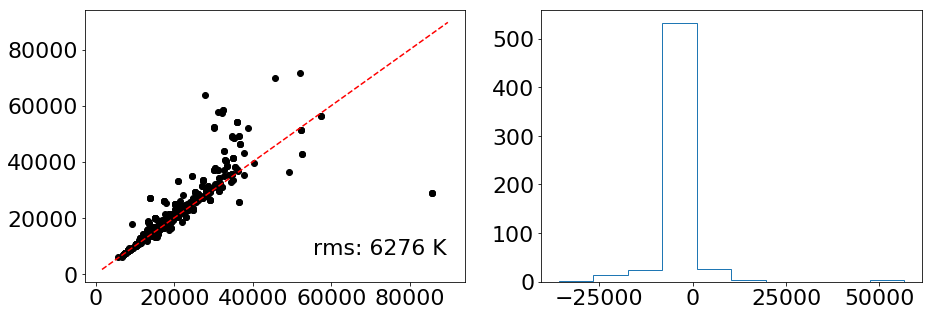

In [232]:
mleteff = [i[0] for i in mles]
lowteff = [i[0] for i in stds]
highteff = [i[0] for i in stds]
plt.figure(figsize=(15,5))
plt.subplot(121)
resid = wdtable['Teff'][0:len(mles)]-mleteff
rms = np.sqrt(np.mean(resid**2))
f = plt.scatter(wdtable['Teff'][0:len(mles)],mleteff, color = 'k')
plt.text(0.6,0.1,'rms: %i K'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.subplot(122)
plt.hist(resid, histtype = 'step');

Text(0, 0.5, 'Fitted $T_{eff}$ (K)')

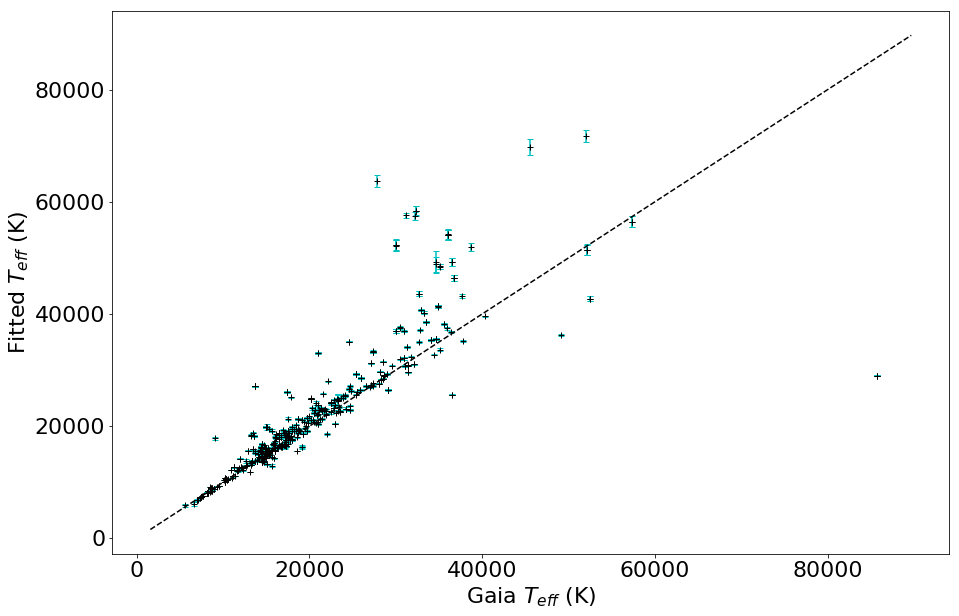

In [233]:
mleteff = [i[0] for i in mles]
resid = wdtable['Teff'][0:len(mles)]-mleteff
rms = np.sqrt(np.mean(resid**2))
plt.figure(figsize = (15,10))
f = plt.subplot(111)
plt.errorbar(wdtable['Teff'][0:len(mles)],mleteff, yerr = (lowteff,highteff), linestyle = 'None', marker = '+',\
            color = 'k', ecolor = 'c', capsize = 3)
#plt.text(0.6,0.1,'rms: %i K'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'k--')
plt.xlabel('Gaia $T_{eff}$ (K)')
plt.ylabel('Fitted $T_{eff}$ (K)')

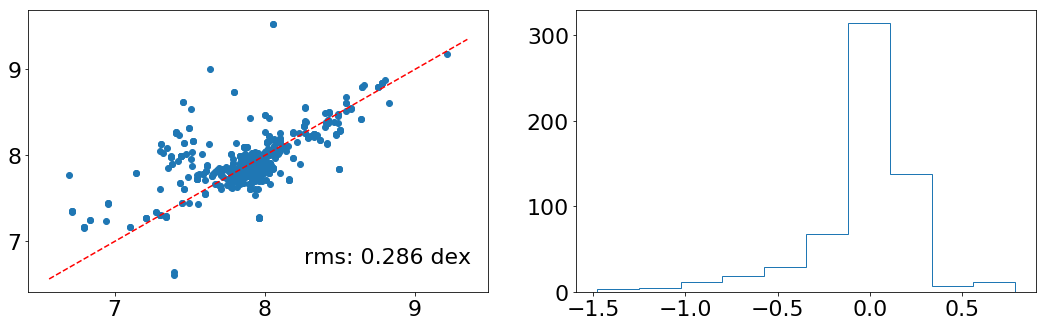

In [234]:
mlelog_g = [i[1] for i in mles]
lowlog_g = [i[1] for i in stds]
highlog_g = [i[1] for i in stds]
plt.figure(figsize=(15,5))
resid = wdtable['log_g'][0:len(mles)]-mlelog_g
rms = np.sqrt(np.mean(resid**2))
plt.subplot(121)
f = plt.scatter(wdtable['log_g'][0:len(mles)],mlelog_g)
plt.text(0.6,0.1,'rms: %.3f dex'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.subplot(122)
plt.hist(resid, histtype = 'step');
plt.tight_layout()

Text(0, 0.5, 'Fitted $\\log{g}$ (dex)')

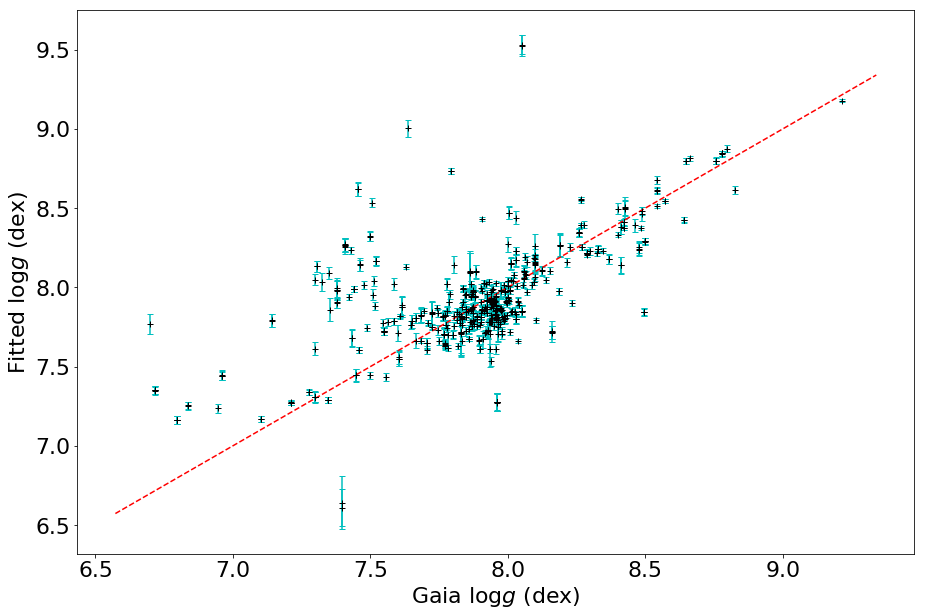

In [235]:
mlelog_g = [i[1] for i in mles]
resid = wdtable['log_g'][0:len(mles)]-mlelog_g
rms = np.sqrt(np.mean(resid**2))
plt.figure(figsize = (15,10))
f = plt.subplot(111)
plt.errorbar(wdtable['log_g'][0:len(mles)],mlelog_g, yerr = (lowlog_g,highlog_g), linestyle = 'None', marker = '.',\
            color = 'k', ecolor = 'c', capsize = 3)
#plt.text(0.6,0.1,'rms: %.2f dex'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.xlabel('Gaia $\log{g}$ (dex)')
plt.ylabel('Fitted $\log{g}$ (dex)')